# Prediction of sugarcane productivity in the state of São Paulo

This project is part of the TCC in Data Science and Analytics at ESALQ/USP. In this project, my main objective is to predict the productivity of sugarcane in the municipalities of the State of São Paulo, using historical series of 21 years and other environmental variables.

All data on productivity (kg/ha), planted area (ha), harvested area (ha), quantity produced (tn) and production value (R$) were obtained from the SIDRA website, from IBGE. Data on climate, vegetation and soil variables were obtained in Google Earth Engine from various sources, in raster form. The average of each raster was calculated for each municipality. Among the variables used are the minimum and maximum temperature, accumulated precipitation and soil moisture, extracted from TERRACLIMATE. The NDVI (Normalized Difference Vegetation Index), NPP (Net Primary Productivity) and LST (Land surface temperature) were obtained from MODIS.

Next, a description of the main steps will be provided. The first is about the treatment of the IBGE tables and later about the environmental variables.

## Part 1: Exploratory analysis and cleaning of data obtained from the IBGE website

In this first part we will analyze the productivity data for each municipality. The steps consist of separating the original csv in each of the tables and filling in the missing values

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas as gp
import earthpy.plot as ep
import missingno
import folium
import rioxarray
import xarray
import sys
import warnings
import rasterio
import seaborn as sns
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from shapely import geometry
pd.set_option('display.max_rows', None)

In [ ]:
# Load data and create 'chunks' for each table. Save separately to computer
for i, chunk in enumerate(pd.read_csv('tabela1612.csv',  encoding ='ISO-8859-1', decimal = ',', sep = ';', chunksize=648)):
    chunk.to_csv('chunk{}.csv'.format(i), index=False, encoding ='ISO-8859-1', decimal = '.')

At the end of the original table we have the following descriptions:

  - Absolute zero, not resulting from a calculation or rounding (-)
  - Zero resulting from a calculation or rounding (0)
  - Value does not apply. Ex: It is not possible to obtain the total agricultural production in a given municipality when agricultural products are accounted for with different measurement units (..)
  - Value not available. Ex: The production of beans in a certain municipality was not researched or a certain municipality did not exist in the year of the research (...)
  
After checking the productivity data with the planted area data, it was possible to observe that the municipalities that do not have numerical values and present any of the symbols mentioned above, do not have a value for some of the reasons mentioned above, but mainly because there was no record of planted area. Then, we will use two strategies, the first one will be to replace all the symbols with NaN that will later be filled with the average, to complete all the spaces. The second strategy will be to use the data with the NaNs.

The first step then is to replace the symbols with 'NaN'


### Load the tables productivity (kg/ha), planted area (ha), harvested area (ha), produced quantity (tn) and production value (R$)

In [3]:
# Load the table that contains the sugarcane productivity for each year. Delete the first 4 lines and the last 2.
# Create a list of symbols representing the missing values and use this list to replace NAs.
lista_ausentes = ['-', '..', '...']
dat_yield = pd.read_csv("tables/chunk5.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_yield.reset_index(drop = True, inplace = True)
dat_yield.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_yield.head()

CD_MUN                    MUN   2000   2001   2002   2003    2004   2005  \
0  3500105        Adamantina (SP)  50000  80000  76311  77794   80000  81307   
1  3500204            Adolfo (SP)    NaN  80000    NaN    NaN  120000  89009   
2  3500303             Aguaí (SP)  80000    NaN  87000  86089   86000  85434   
3  3500402    Águas da Prata (SP)    NaN    NaN    NaN    NaN     NaN    NaN   
4  3500501  Águas de Lindóia (SP)    NaN    NaN    NaN    NaN     NaN    NaN   

     2006    2007  ...   2011   2012    2013    2014   2015   2016   2017  \
0   75000  100000  ...  75000  60000   70000   60000  80000  80000  80000   
1  100000  100000  ...  90000  90000   90000   70000  70000  80000  90000   
2   85000   85000  ...  90000  90000  100000  100000  80000  90000  90000   
3     NaN     NaN  ...  60000  90000   90000   90000    NaN    NaN    NaN   
4     NaN     NaN  ...    NaN    NaN     NaN     NaN    NaN    NaN    NaN   

    2018   2019   2020  
0  70000  75000  70000  
1  90000  90000  90000  
2  85000  85000  85000  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  

[5 rows x 23 columns]

In [4]:
# Carregar a tabela area plantada (ap)
dat_ap = pd.read_csv("tables/chunk0.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_ap.reset_index(drop = True, inplace = True)
dat_ap.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_ap.head()

CD_MUN                    MUN  2000  2001  2002  2003  2004  2005   2006  \
0  3500105        Adamantina (SP)  7000  7000  8048  7644  8300  8603   8000   
1  3500204            Adolfo (SP)   NaN  8000   NaN   NaN   968  1104   1114   
2  3500303             Aguaí (SP)  5250   NaN  4200  7180  7850  7664  10200   
3  3500402    Águas da Prata (SP)   NaN   NaN   NaN   NaN   NaN   NaN    NaN   
4  3500501  Águas de Lindóia (SP)   NaN   NaN   NaN   NaN   NaN   NaN    NaN   

    2007  ...   2011   2012   2013   2014   2015   2016   2017   2018   2019  \
0  12000  ...  13000  13000  13000  12115  12950  12900  12800  13000  12500   
1   3418  ...   4461   4461   4461   6209   6309   5809   7320   7266   7016   
2   8000  ...  12000  12500  12500  12500  12500  12500  12500  11500  11500   
3    NaN  ...     85     70     70     70    NaN    NaN    NaN    NaN    NaN   
4    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    2020  
0  11349  
1   5015  
2  11500  
3    NaN  
4    NaN  

[5 rows x 23 columns]

In [5]:
# Carregar a tabela area colhida(ac)
dat_ac = pd.read_csv("tables/chunk2.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_ac.reset_index(drop = True, inplace = True)
dat_ac.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_ac.head()

CD_MUN                    MUN  2000  2001  2002  2003  2004  2005   2006  \
0  3500105        Adamantina (SP)  7000  7000  8048  7644  8300  8603   8000   
1  3500204            Adolfo (SP)   NaN  8000   NaN   NaN   968  1104   1114   
2  3500303             Aguaí (SP)  5250   NaN  4200  7180  7850  7664  10200   
3  3500402    Águas da Prata (SP)   NaN   NaN   NaN   NaN   NaN   NaN    NaN   
4  3500501  Águas de Lindóia (SP)   NaN   NaN   NaN   NaN   NaN   NaN    NaN   

    2007  ...   2011   2012   2013   2014   2015   2016   2017   2018   2019  \
0  12000  ...  13000  13000  13000  12115  12950  12900  12800  13000  12500   
1   3418  ...   4461   4461   4461   6209   6309   5809   7320   7266   7016   
2   8000  ...  12000  12500  12500  12500  12500  12500  12500  11500  11500   
3    NaN  ...     85     70     70     70    NaN    NaN    NaN    NaN    NaN   
4    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    2020  
0  11349  
1   5015  
2  11500  
3    NaN  
4    NaN  

[5 rows x 23 columns]

In [6]:
# Carregar a tabela quantidade produzida (qp)
dat_qp = pd.read_csv("tables/chunk4.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_qp.reset_index(drop = True, inplace = True)
dat_qp.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_qp.head()

CD_MUN                    MUN    2000    2001    2002    2003    2004  \
0  3500105        Adamantina (SP)  350000  560000  614158  594663  664000   
1  3500204            Adolfo (SP)     NaN  640000     NaN     NaN  116160   
2  3500303             Aguaí (SP)  420000     NaN  365400  618126  675100   
3  3500402    Águas da Prata (SP)     NaN     NaN     NaN     NaN     NaN   
4  3500501  Águas de Lindóia (SP)     NaN     NaN     NaN     NaN     NaN   

     2005    2006     2007  ...     2011     2012     2013     2014     2015  \
0  699491  600000  1200000  ...   975000   780000   910000   726900  1036000   
1   98267  111400   341800  ...   401490   401490   401490   434630   441630   
2  654770  867000   680000  ...  1080000  1125000  1250000  1250000  1000000   
3     NaN     NaN      NaN  ...     5100     6300     6300     6300      NaN   
4     NaN     NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   

      2016     2017    2018    2019    2020  
0  1032000  1024000  910000  937500  794430  
1   464720   658800  653940  631440  451350  
2  1125000  1125000  977500  977500  977500  
3      NaN      NaN     NaN     NaN     NaN  
4      NaN      NaN     NaN     NaN     NaN  

[5 rows x 23 columns]

In [7]:
# Carregar a tabela valor da produção (vp)
dat_vp = pd.read_csv("tables/chunk6.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_vp.reset_index(drop = True, inplace = True)
dat_vp.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_vp.head()

CD_MUN                    MUN  2000   2001   2002   2003   2004   2005  \
0  3500105        Adamantina (SP)  6244  13294  18713  19029  15936  20110   
1  3500204            Adolfo (SP)   NaN  15194    NaN    NaN   2765   3484   
2  3500303             Aguaí (SP)  7493    NaN  11134  16689  16202  18334   
3  3500402    Águas da Prata (SP)   NaN    NaN    NaN    NaN    NaN    NaN   
4  3500501  Águas de Lindóia (SP)   NaN    NaN    NaN    NaN    NaN    NaN   

    2006   2007  ...   2011   2012   2013   2014   2015   2016   2017   2018  \
0  19800  37200  ...  40950  49600  55965  43003  61756  59330  60467  55783   
1   3609  10596  ...  21680  22098  22138  21975  23680  31633  45872  43082   
2  27744  24480  ...  42120  69210  75325  70250  53530  67568  68625  63538   
3    NaN    NaN  ...    189    370    380    357    NaN    NaN    NaN    NaN   
4    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    2019   2020  
0  60094  51709  
1  44700  32497  
2  66793  70869  
3    NaN    NaN  
4    NaN    NaN  

[5 rows x 23 columns]

In [8]:
# Conferir o tamanho das tabelas
print('The yield (kg/ha) dataframe has {} rows and {} columns'.format(dat_yield.shape[0], dat_yield.shape[1]))
print('The planted area (ha) dataframe has {} rows and {} columns'.format(dat_ap.shape[0], dat_ap.shape[1]))
print('The harvested area (ha) dataframe has {} rows and {} columns'.format(dat_ac.shape[0], dat_ac.shape[1]))
print('The total production (tn) dataframe has {} rows and {} columns'.format(dat_qp.shape[0], dat_qp.shape[1]))
print('The production value (R$) dataframe has {} rows and {} columns'.format(dat_vp.shape[0], dat_vp.shape[1]))

The yield (kg/ha) dataframe has 642 rows and 23 columns
The planted area (ha) dataframe has 642 rows and 23 columns
The harvested area (ha) dataframe has 642 rows and 23 columns
The total production (tn) dataframe has 642 rows and 23 columns
The production value (R$) dataframe has 642 rows and 23 columns


In [ ]:
# Info yield
dat_yield.info()

In [ ]:
# Info ap
dat_ap.info()

In [ ]:
# Info ac
dat_ac.info()

In [ ]:
# Info qpa
dat_qp.info()

In [ ]:
# Info vp
dat_vp.info()

All columns were read as 'object'. So we need to convert to numeric

In [9]:
# Select columns to convert
cols = dat_yield.columns.drop(['CD_MUN', 'MUN']).tolist()

In [10]:
# Convert columns to numeric type
dat_yield[cols] = dat_yield[cols].apply(pd.to_numeric)
dat_ap[cols] = dat_ap[cols].apply(pd.to_numeric)
dat_ac[cols] = dat_ac[cols].apply(pd.to_numeric)
dat_qp[cols] = dat_qp[cols].apply(pd.to_numeric)
dat_vp[cols] = dat_vp[cols].apply(pd.to_numeric)
dat_vp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CD_MUN  642 non-null    object 
 1   MUN     642 non-null    object 
 2   2000    381 non-null    float64
 3   2001    383 non-null    float64
 4   2002    419 non-null    float64
 5   2003    421 non-null    float64
 6   2004    440 non-null    float64
 7   2005    450 non-null    float64
 8   2006    467 non-null    float64
 9   2007    483 non-null    float64
 10  2008    506 non-null    float64
 11  2009    500 non-null    float64
 12  2010    522 non-null    float64
 13  2011    530 non-null    float64
 14  2012    491 non-null    float64
 15  2013    515 non-null    float64
 16  2014    511 non-null    float64
 17  2015    508 non-null    float64
 18  2016    512 non-null    float64
 19  2017    514 non-null    float64
 20  2018    518 non-null    float64
 21  2019    517 non-null    float64
 22  20

In the information presented for each table, it is possible to observe that we do not have data for all Municipalities in all years. If complete, the total for all columns should be 642 in the middle column. So we see that there is a lot of missing data. In the next codes we will analyze this missing data only in the productivity table (dat_yield). We will exclude rows that do not have productivity values for all years and those with more than 40% missing values. After excluding these values, the remaining lines with the municipality code were used to select the municipalities from the other tables and have a similar database.

Na tabela acima podemos observar que não temos dados para todos os Municípios em todos os anos. Se completo, deveria ser 642 na linha 'count'. Portanto, vemos que há muitos dados faltantes. Nos próximos códigos vamos analisar esses dados faltantes e como proceder da melhor forma.

In [11]:
# Function to calculate the total of missing values
def calc_ausentes(df):

    # Total values in the dataset
    total_values = np.product(df.shape)

    # Number of missing values per column
    colvalues_missing = df.isnull().sum()

    # Total missing values and percentage
    missing_total = colvalues_missing.sum()
    missing_percent = round(((missing_total/total_values) * 100), 2)

    # Print result
    print('Dataset has {}% missing values'.format(missing_percent))
    
    
# Function to calculate missing values by column
def cal_ausentes_coluna(df):
    
    # Number of missing values per column
    col_missing = df.isnull().sum()

    # Number of missing values per column
    col_missing_percent = 100 * col_missing / len(df)

    # Data type of columns with missing values
    col_missing_dtype = df.dtypes

    # Create a table with the results
    col_missing_table = pd.concat([col_missing, col_missing_percent, col_missing_dtype], axis=1)

    # Rename the columns
    col_missing_table = col_missing_table.rename(
    columns = {0 : 'Missing values', 1 : '% of Missing values', 2: 'Dtype'})

    # Sort the table by percentage of missing values descending and remove columns with no missing values
    col_missing_table = col_missing_table[\
                                          col_missing_table.iloc[:,0] != 0].sort_values('% of Missing values', \
                                                                                        ascending = False).round(2)

    # Print 
    print ("The dataset has " + str(df.shape[1]) + " columns.\n"
        "Found: " + str(col_missing_table.shape[0]) + " columns with missing values.")

    if col_missing_table.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return col_missing_table

# Function that calculates the percentage of rows with missing values
def calc_ausentes_linha(df):

    # Calculates the total number of rows with missing values
    missing_rows = sum([True for idx, row in df.iterrows() if any(row.isna())])

    # Calculate the total number of lines
    total_rows = df.shape[0]

    # Calculates the percentage of missing lines
    percen_ausentes = round(((missing_rows/total_rows) * 100), 2)
    
    print('Dataset has {} % of rows with at least one missing value.'.format(percen_ausentes))

In [12]:
# Check the percentage of missing values
calc_ausentes(dat_yield)

Dataset has 22.89% missing values


In [13]:
# Check missing values in columns
cal_ausentes_coluna(dat_yield)

The dataset has 23 columns.
Found: 21 columns with missing values.


Missing values  % of Missing values    Dtype
2000             261                40.65  float64
2001             259                40.34  float64
2002             224                34.89  float64
2003             221                34.42  float64
2004             204                31.78  float64
2005             192                29.91  float64
2006             175                27.26  float64
2007             159                24.77  float64
2012             151                23.52  float64
2009             142                22.12  float64
2008             136                21.18  float64
2015             134                20.87  float64
2014             131                20.40  float64
2016             130                20.25  float64
2017             128                19.94  float64
2020             127                19.78  float64
2013             126                19.63  float64
2019             124                19.31  float64
2018             123                19.16  float64
2010             121                18.85  float64
2011             112                17.45  float64

In [14]:
# Check for missing values in lines
calc_ausentes_linha(dat_yield)

Dataset has 51.09 % of rows with at least one missing value.


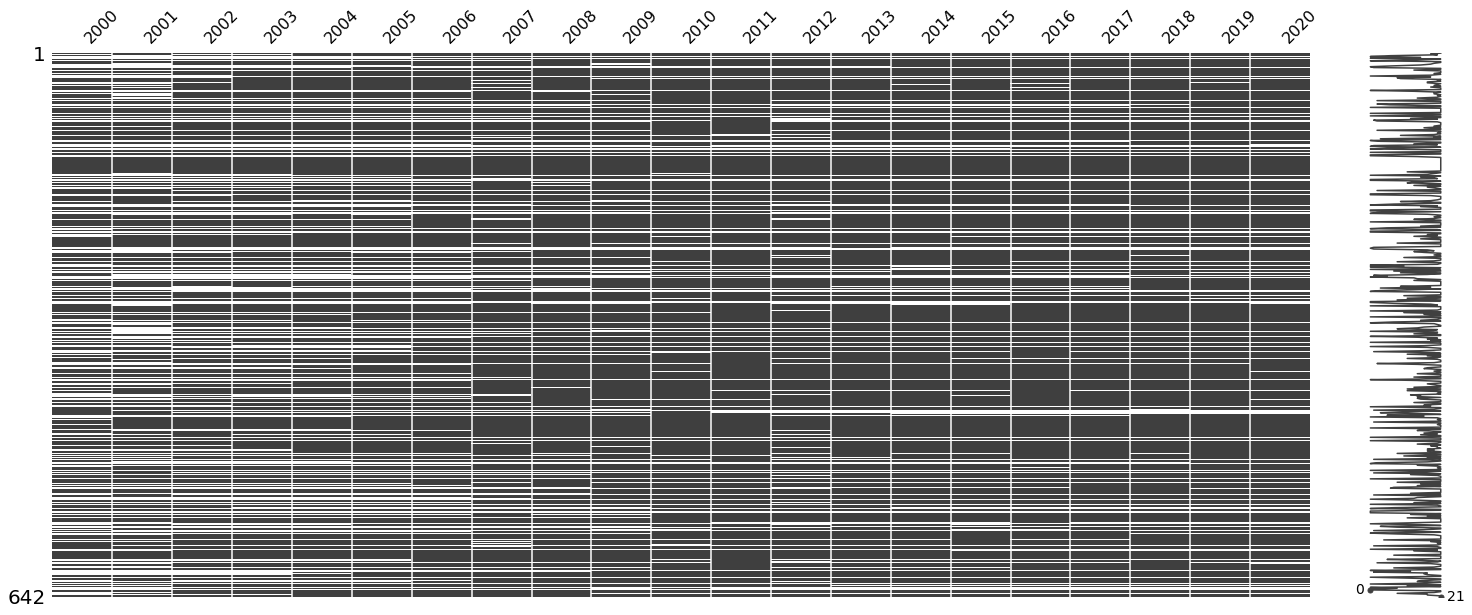

In [15]:
# Plot map of missing values
dat_yield_nan = pd.DataFrame(dat_yield.isna().sum())

if dat_yield.isna().any(axis = None):
    missingno.matrix(dat_yield[dat_yield_nan[dat_yield_nan[0]>0].index])
    plt.show()

We have a pattern of variation in the data. There are entire lines with empty cells, which means that several municipalities did not produce sugarcane in any of the years studied. Then, the next step is to identify the percentage of these missing values in each row and column. At first we will focus on deleting the missing values in the rows for all years.

What you need to do now is count the null values for each municipality, to make sure if it's just a few values missing or the percentage is higher. If the missing values in each municipality represent more than 40%, the municipality will be excluded from the analysis

In [18]:
# Count rows with missing values
missing_rows = sum([True for idx,row in dat_yield.iterrows() if any(row.isna())])
print("We have {} rows with missing values".format(missing_rows))

We have 328 rows with missing values


In [24]:
## Create a dataframe with the percentage of missing values calculation for each row
rows_missing = dat_yield.isnull().sum(axis=1)
rows_perc = round(((rows_missing / 21) * 100), 2)
mis_val_table = pd.concat([dat_yield['MUN'], rows_missing, rows_perc], axis = 1)
mis_val_table.rename(columns = {0: 'Missing total', 1: '% Missing'}, inplace = True)
mis_val_table.head()


MUN  Missing total  % Missing
0        Adamantina (SP)              0       0.00
1            Adolfo (SP)              3      14.29
2             Aguaí (SP)              1       4.76
3    Águas da Prata (SP)             15      71.43
4  Águas de Lindóia (SP)             21     100.00

In [32]:
# Contar as linhas com 100% e > 50% de valores ausentes
rows_to_remove = mis_val_table[mis_val_table['% Missing'] == 100].index.tolist()
rows_40perc = mis_val_table[mis_val_table['% Missing'] >= 40.00].index.tolist()
print('There are {} rows with no record of sugarcane production for all years'.format(len(rows_to_remove)))
print('There are {} rows with more than 40% missing values'.format(len(rows_40perc)))

There are 68 rows with no record of sugarcane production for all years
There are 156 rows with more than 40% missing values


In [27]:
dat_yield.iloc[rows_40perc].head()

CD_MUN                      MUN  2000  2001  2002  2003  2004  2005  \
3   3500402      Águas da Prata (SP)   NaN   NaN   NaN   NaN   NaN   NaN   
4   3500501    Águas de Lindóia (SP)   NaN   NaN   NaN   NaN   NaN   NaN   
6   3500600  Águas de São Pedro (SP)   NaN   NaN   NaN   NaN   NaN   NaN   
9   3500808   Alfredo Marcondes (SP)   NaN   NaN   NaN   NaN   NaN   NaN   
15  3501301     Álvares Machado (SP)   NaN   NaN   NaN   NaN   NaN   NaN   

    2006  2007  ...     2011     2012     2013     2014     2015     2016  \
3    NaN   NaN  ...  60000.0  90000.0  90000.0  90000.0      NaN      NaN   
4    NaN   NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
6    NaN   NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9    NaN   NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
15   NaN   NaN  ...      NaN      NaN      NaN  75000.0  75000.0  75000.0   

       2017      2018      2019      2020  
3       NaN       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN  
6       NaN       NaN       NaN       NaN  
9       NaN       NaN       NaN       NaN  
15  80000.0  100000.0  100000.0  100000.0  

[5 rows x 23 columns]

After checking the missing values, we conclude that 156 rows will be removed.

In [28]:
# Remove the data with more than 40% of NaN values
dat_yield_clean = dat_yield.drop(rows_40perc)
dat_yield_clean.shape

(486, 23)

Let's re-plot the graph to check the pattern of missing values

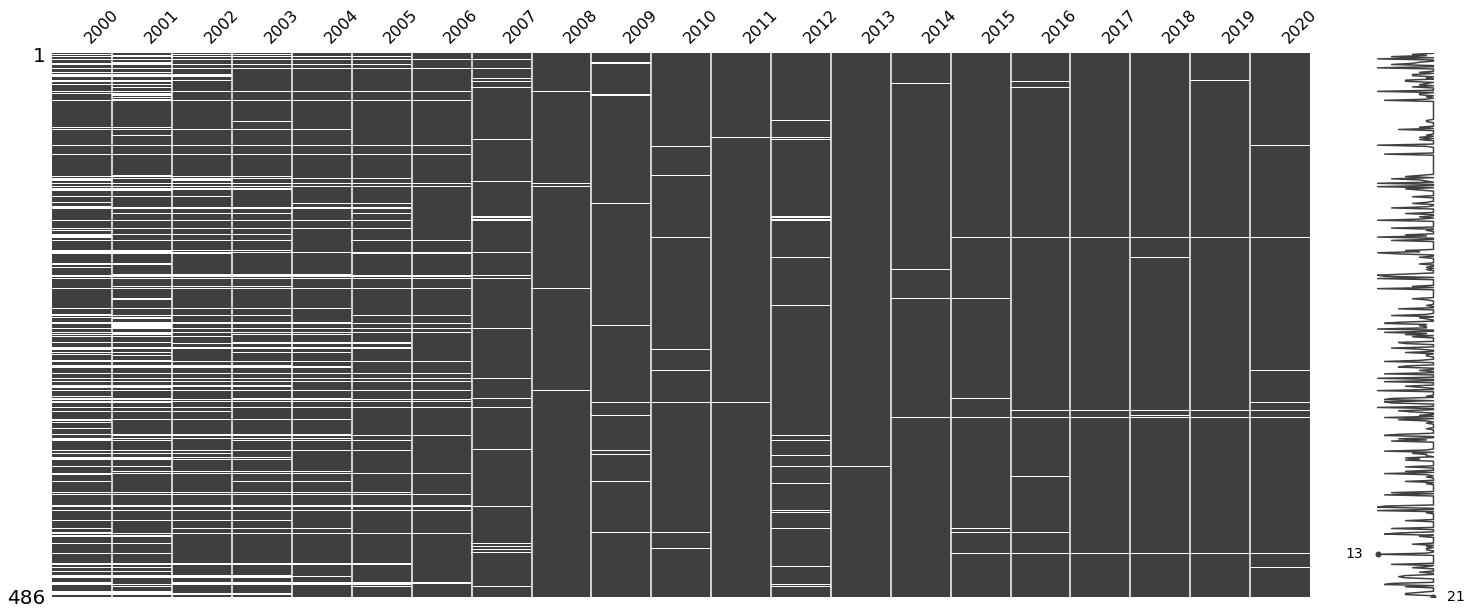

In [29]:
# Plot - Map of Missing Values
dat_nan = pd.DataFrame(dat_yield_clean.isna().sum())

if dat_yield_clean.isna().any(axis = None):
    missingno.matrix(dat_yield_clean[dat_yield_nan[dat_yield_nan[0]>0].index])
    plt.show()

In [31]:
# Count rows with missing values
missing_rows = sum([True for idx,row in dat_yield_clean.iterrows() if any(row.isna())])
print("There are {} rows with missing values". format(missing_rows))

There are 172 rows with missing values


So far, we have identified missing values and excluding those that are not useful for our analysis. We still have 172 municipalities with missing values. However, for now, let's leave it and then come back to it. Let's plot a heat map to see the yield values.  
To correctly plot the graphs, the data will be reshaped, using the merge function. This will create a new dataframe with all the years in a single column.

In [33]:
# Name is id_vars and Course is value_vars
dat_clean_melt = pd.melt(dat_yield_clean, id_vars =['CD_MUN', 'MUN'])
heatmap_data = pd.pivot_table(dat_clean_melt,values='value', index=['MUN'], columns='variable')
heatmap_data.head()

variable            2000     2001     2002     2003      2004     2005  \
MUN                                                                      
Adamantina (SP)  50000.0  80000.0  76311.0  77794.0   80000.0  81307.0   
Adolfo (SP)          NaN  80000.0      NaN      NaN  120000.0  89009.0   
Aguaí (SP)       80000.0      NaN  87000.0  86089.0   86000.0  85434.0   
Agudos (SP)      70000.0  70000.0  70000.0  70000.0   77996.0  77723.0   
Alambari (SP)        NaN      NaN      NaN      NaN       NaN      NaN   

variable             2006      2007     2008     2009  ...     2011     2012  \
MUN                                                    ...                     
Adamantina (SP)   75000.0  100000.0  90000.0  80000.0  ...  75000.0  60000.0   
Adolfo (SP)      100000.0  100000.0  80000.0  90000.0  ...  90000.0  90000.0   
Aguaí (SP)        85000.0   85000.0  89080.0  90000.0  ...  90000.0  90000.0   
Agudos (SP)       80000.0   88669.0  80000.0  80000.0  ...  79500.0  79500.0   
Alambari (SP)         NaN       NaN  75000.0  88888.0  ...  92300.0  70000.0   

variable             2013      2014     2015     2016     2017     2018  \
MUN                                                                       
Adamantina (SP)   70000.0   60000.0  80000.0  80000.0  80000.0  70000.0   
Adolfo (SP)       90000.0   70000.0  70000.0  80000.0  90000.0  90000.0   
Aguaí (SP)       100000.0  100000.0  80000.0  90000.0  90000.0  85000.0   
Agudos (SP)       79500.0   60004.0  64794.0  61000.0  70000.0  61000.0   
Alambari (SP)     80000.0   72800.0  80000.0  80000.0  80000.0  80000.0   

variable            2019     2020  
MUN                                
Adamantina (SP)  75000.0  70000.0  
Adolfo (SP)      90000.0  90000.0  
Aguaí (SP)       85000.0  85000.0  
Agudos (SP)      70000.0  70000.0  
Alambari (SP)    80000.0  80000.0  

[5 rows x 21 columns]

In [34]:
# Size
dat_clean_melt.shape

(10206, 4)

In [ ]:
# Save as csv to use later
dat_clean_melt.to_csv("dat_yield_melt_all_years.csv")

In [38]:
# Creating heatmap
heatmap_data = pd.pivot_table(dat_clean_melt,values='value', index=['MUN'], columns='variable')
heatmap_data.head()

variable            2000     2001     2002     2003      2004     2005  \
MUN                                                                      
Adamantina (SP)  50000.0  80000.0  76311.0  77794.0   80000.0  81307.0   
Adolfo (SP)          NaN  80000.0      NaN      NaN  120000.0  89009.0   
Aguaí (SP)       80000.0      NaN  87000.0  86089.0   86000.0  85434.0   
Agudos (SP)      70000.0  70000.0  70000.0  70000.0   77996.0  77723.0   
Alambari (SP)        NaN      NaN      NaN      NaN       NaN      NaN   

variable             2006      2007     2008     2009  ...     2011     2012  \
MUN                                                    ...                     
Adamantina (SP)   75000.0  100000.0  90000.0  80000.0  ...  75000.0  60000.0   
Adolfo (SP)      100000.0  100000.0  80000.0  90000.0  ...  90000.0  90000.0   
Aguaí (SP)        85000.0   85000.0  89080.0  90000.0  ...  90000.0  90000.0   
Agudos (SP)       80000.0   88669.0  80000.0  80000.0  ...  79500.0  79500.0   
Alambari (SP)         NaN       NaN  75000.0  88888.0  ...  92300.0  70000.0   

variable             2013      2014     2015     2016     2017     2018  \
MUN                                                                       
Adamantina (SP)   70000.0   60000.0  80000.0  80000.0  80000.0  70000.0   
Adolfo (SP)       90000.0   70000.0  70000.0  80000.0  90000.0  90000.0   
Aguaí (SP)       100000.0  100000.0  80000.0  90000.0  90000.0  85000.0   
Agudos (SP)       79500.0   60004.0  64794.0  61000.0  70000.0  61000.0   
Alambari (SP)     80000.0   72800.0  80000.0  80000.0  80000.0  80000.0   

variable            2019     2020  
MUN                                
Adamantina (SP)  75000.0  70000.0  
Adolfo (SP)      90000.0  90000.0  
Aguaí (SP)       85000.0  85000.0  
Agudos (SP)      70000.0  70000.0  
Alambari (SP)    80000.0  80000.0  

[5 rows x 21 columns]

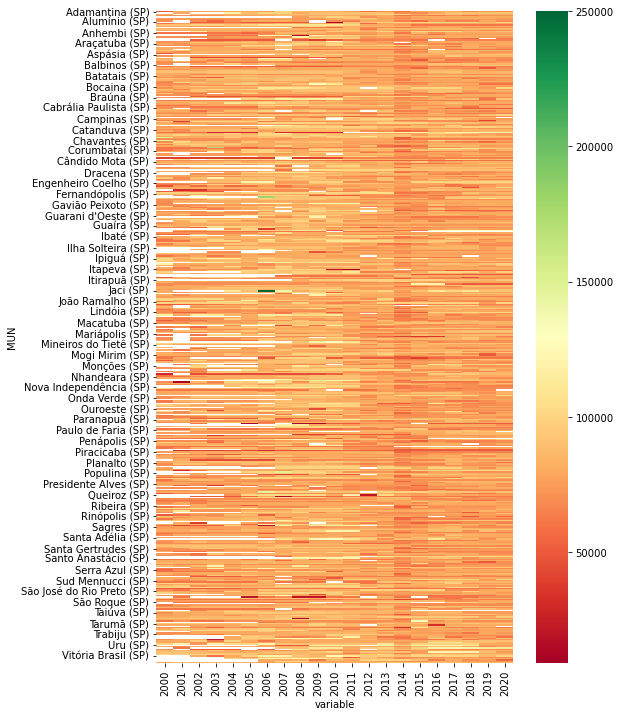

In [39]:
# Plot heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, cmap='RdYlGn')
plt.show()

Here we can see another problem. It has productivity above 200,000 kg/ha, a situation that is not very common and that can interfere with our analysis. Therefore, we will identify these municipalities and exclude them from the database.

In [41]:
# Search counties with > 200000
dat_yield_clean.loc[dat_yield_clean['2006'] >= 200000]

CD_MUN        MUN     2000  2001  2002  2003      2004     2005  \
276  3524501  Jaci (SP)  80000.0   NaN   NaN   NaN  110000.0  89396.0   

         2006      2007  ...     2011     2012      2013     2014     2015  \
276  250000.0  140000.0  ...  90000.0  90000.0  100000.0  75000.0  90000.0   

         2016      2017      2018     2019     2020  
276  110000.0  100000.0  110000.0  90000.0  90000.0  

[1 rows x 23 columns]

In [43]:
# Drop the county with yield > 200000
dat_yield_clean.drop(276, inplace = True)

In [44]:
# Search again counties with > 200000
dat_yield_clean.loc[dat_yield_clean['2006'] >= 200000]

Empty DataFrame
Columns: [CD_MUN, MUN, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Index: []

[0 rows x 23 columns]

In [46]:
# Reset index
dat_yield_clean.reset_index(drop = True, inplace = True)
dat_yield_clean.head()

CD_MUN                          MUN     2000     2001     2002     2003  \
0  3500105              Adamantina (SP)  50000.0  80000.0  76311.0  77794.0   
1  3500204                  Adolfo (SP)      NaN  80000.0      NaN      NaN   
2  3500303                   Aguaí (SP)  80000.0      NaN  87000.0  86089.0   
3  3500550  Águas de Santa Bárbara (SP)      NaN      NaN      NaN      NaN   
4  3500709                  Agudos (SP)  70000.0  70000.0  70000.0  70000.0   

       2004     2005      2006      2007  ...     2011      2012      2013  \
0   80000.0  81307.0   75000.0  100000.0  ...  75000.0   60000.0   70000.0   
1  120000.0  89009.0  100000.0  100000.0  ...  90000.0   90000.0   90000.0   
2   86000.0  85434.0   85000.0   85000.0  ...  90000.0   90000.0  100000.0   
3       NaN      NaN   80333.0   80000.0  ...  80000.0  100000.0  100000.0   
4   77996.0  77723.0   80000.0   88669.0  ...  79500.0   79500.0   79500.0   

       2014     2015     2016     2017     2018     2019     2020  
0   60000.0  80000.0  80000.0  80000.0  70000.0  75000.0  70000.0  
1   70000.0  70000.0  80000.0  90000.0  90000.0  90000.0  90000.0  
2  100000.0  80000.0  90000.0  90000.0  85000.0  85000.0  85000.0  
3  100000.0  90000.0  63000.0  80000.0  70000.0  75000.0  55000.0  
4   60004.0  64794.0  61000.0  70000.0  61000.0  70000.0  70000.0  

[5 rows x 23 columns]

Now we don't have any more values to delete. Let's use the CD_MUN list from dat_yield to select the rows in the other datasets.

In [47]:
# Create a list with the CD_MUN codes and use this list to select the rows from the other datasets
list_mun = dat_yield_clean['CD_MUN']
dat_ap_clean = dat_ap[dat_ap['CD_MUN'].isin(list_mun)].reset_index(drop = True)
dat_ac_clean = dat_ac[dat_ac['CD_MUN'].isin(list_mun)].reset_index(drop = True)
dat_qp_clean = dat_qp[dat_qp['CD_MUN'].isin(list_mun)].reset_index(drop = True)
dat_vp_clean = dat_vp[dat_ap['CD_MUN'].isin(list_mun)].reset_index(drop = True)
print('The yield (kg/ha) dataset has {} rows and {} columns'.format(dat_yield_clean.shape[0], 
                                                                                      dat_yield_clean.shape[1]))
print('The planted area (ha) dataset has {} rows and {} columns'.format(dat_ap_clean.shape[0], 
                                                                                   dat_ap_clean.shape[1]))
print('The harvested area (ha) dataset has {} rows and {} columns'.format(dat_ac_clean.shape[0], 
                                                                                     dat_ac_clean.shape[1]))
print('The total production (tn) dataset has {} rows and {} columns'.format(dat_qp_clean.shape[0], 
                                                                                          dat_qp_clean.shape[1]))
print('The production value (R$) dataset has {} rows and {} columns'.format(dat_vp_clean.shape[0], 
                                                                                              dat_vp_clean.shape[1]))

The yield (kg/ha) dataset has 485 rows and 23 columns
The planted area (ha) dataset has 485 rows and 23 columns
The harvested area (ha) dataset has 485 rows and 23 columns
The total production (tn) dataset has 485 rows and 23 columns
The production value (R$) dataset has 485 rows and 23 columns


Databases are ready to be joined. The next step is to reshape the data, using the melt function. After that, a join

In [48]:
# Reshape
dat_yield_melt = pd.melt(dat_yield_clean, id_vars = ['CD_MUN', 'MUN'])
dat_yield_melt.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
dat_ap_melt = pd.melt(dat_ap_clean, id_vars = ['CD_MUN', 'MUN'])
dat_ap_melt.rename(columns = {'variable': 'Year', 'value': 'AP'}, inplace = True)
dat_ac_melt = pd.melt(dat_ac_clean, id_vars = ['CD_MUN', 'MUN'])
dat_ac_melt.rename(columns = {'variable': 'Year', 'value': 'AC'}, inplace = True)
dat_qp_melt = pd.melt(dat_qp_clean, id_vars = ['CD_MUN', 'MUN'])
dat_qp_melt.rename(columns = {'variable': 'Year', 'value': 'QP'}, inplace = True)
dat_vp_melt = pd.melt(dat_vp_clean, id_vars = ['CD_MUN', 'MUN'])
dat_vp_melt.rename(columns = {'variable': 'Year', 'value': 'VP'}, inplace = True)
dat_vp_melt.shape

(10185, 4)

After reshaping the data, the environmental variables obtained in Google Earth Engine and processed in QGIS will be loaded here, in order to merge with the IBGE data.

### Load the environmental variables obtained in the GEE

In [49]:
# Load the environmental variables files and create a new dataset with only the IDs selected in the previous cell
list_mun = dat_yield_clean['CD_MUN'].astype(int).reset_index(drop = True)
aet = pd.read_csv('tables/aet.csv', sep = ';')
aet_new = aet[aet['CD_MUN'].isin(list_mun)].reset_index(drop = True)
ndvi = pd.read_csv('tables/ndvi.csv', sep = ';')
ndvi_new = ndvi[ndvi['CD_MUN'].isin(list_mun)].reset_index(drop = True)
npp = pd.read_csv('tables/npp.csv', sep = ';')
npp_new = npp[npp['CD_MUN'].isin(list_mun)].reset_index(drop = True)
soil = pd.read_csv('tables/soil.csv', sep = ';')
soil_new = soil[soil['CD_MUN'].isin(list_mun)].reset_index(drop = True)
pr = pd.read_csv('tables/pr.csv', sep = ';')
pr_new = pr[pr['CD_MUN'].isin(list_mun)].reset_index(drop = True)
lst = pd.read_csv('tables/LST.csv', sep = ';')
lst_new = lst[lst['CD_MUN'].isin(list_mun)].reset_index(drop = True)
tmmx = pd.read_csv('tables/tmmx.csv', sep = ';')
tmmx_new = tmmx[tmmx['CD_MUN'].isin(list_mun)].reset_index(drop = True)
tmin = pd.read_csv('tables/tmin.csv', sep = ';')
tmin_new = tmin[tmin['CD_MUN'].isin(list_mun)].reset_index(drop = True)

In [50]:
# Reshape the dataset with the melt function
dat_clean_aet = pd.melt(aet_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_aet.rename(columns = {'value': 'AET'}, inplace = True)

dat_clean_ndvi = pd.melt(ndvi_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_ndvi.rename(columns = {'value': 'NDVI'}, inplace = True)

dat_clean_npp = pd.melt(npp_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_npp.rename(columns = {'value': 'NPP'}, inplace = True)

dat_clean_soil = pd.melt(soil_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_soil.rename(columns = {'value': 'SOIL'}, inplace = True)

dat_clean_pr = pd.melt(pr_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_pr.rename(columns = {'value': 'PR'}, inplace = True)

dat_clean_tmmx = pd.melt(tmmx_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_tmmx.rename(columns = {'value': 'TMMX'}, inplace = True)

dat_clean_tmin = pd.melt(tmin_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_tmin.rename(columns = {'value': 'TMIN'}, inplace = True)

dat_clean_lst = pd.melt(lst_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_lst.rename(columns = {'value': 'LST'}, inplace = True)

In [51]:
# Size
dat_clean_lst.shape

(10670, 3)

We see that the tables of the environmental variables have more rows. This is because the data goes up to 2021, unlike the productivity variables, which we only have up to 2020. When the code below is joined, the number of lines will be the same and the year 2021 will be eliminated. However, as we will be using the year 2021 as our test set in the modeling, we will save it as a separate database. For the data of ap, ac, vp and qp we still do not have data for 2021. Therefore, these data will be dealt with later.

In [ ]:
# Select the year 2021 and save as a new csv
dat_aet_2021 = dat_clean_aet.tail(485)
dat_aet_2021['variable'] = dat_aet_2021['variable'].replace('aet_2021', '2021')

dat_ndvi_2021 = dat_clean_ndvi.tail(485)
dat_ndvi_2021['variable'] = dat_ndvi_2021['variable'].replace('ndvi_2021', '2021')

dat_npp_2021 = dat_clean_npp.tail(485)
dat_npp_2021['variable'] = dat_npp_2021['variable'].replace('npp_2021', '2021')

dat_pr_2021 = dat_clean_pr.tail(485)
dat_pr_2021['variable'] = dat_pr_2021['variable'].replace('pr_2021', '2021')

dat_soil_2021 = dat_clean_soil.tail(485)
dat_soil_2021['variable'] = dat_soil_2021['variable'].replace('soil_2021', '2021')

dat_tmmx_2021 = dat_clean_tmmx.tail(485)
dat_tmmx_2021['variable'] = dat_tmmx_2021['variable'].replace('tmmx_2021', '2021')

dat_tmin_2021 = dat_clean_tmin.tail(485)
dat_tmin_2021['variable'] = dat_tmin_2021['variable'].replace('tmin_2021', '2021')

dat_lst_2021 = dat_clean_lst.tail(485)
dat_lst_2021['variable'] = dat_lst_2021['variable'].replace('lst_2021', '2021')

new_data_2021 = dat_aet_2021.join([dat_ndvi_2021['NDVI'], dat_npp_2021['NPP'],  dat_soil_2021['SOIL'], 
                                   dat_tmin_2021['TMIN'], dat_tmmx_2021['TMMX'], dat_pr_2021['PR'], 
                                  dat_lst_2021['LST']])

new_data_2021.to_csv("new_data_all_2021.csv", index = False)

In [56]:
# Join all datasets without the year 2021
new_data = dat_yield_melt.join([dat_ap_melt['AP'], dat_ac_melt['AC'], dat_qp_melt['QP'], dat_vp_melt['VP'],
                               dat_clean_aet['AET'], dat_clean_ndvi['NDVI'], dat_clean_npp['NPP'], dat_clean_soil['SOIL'],
                                dat_clean_tmin['TMIN'], dat_clean_tmmx['TMMX'], dat_clean_pr['PR'], dat_clean_lst['LST']])
print('The clean dataset has {} rows and {} columns)'.format(new_data.shape[0], new_data.shape[1]))

The clean dataset has 10185 rows and 16 columns)


In [57]:
# A glimpse on the datasets
new_data.head()

CD_MUN                          MUN  Year    Yield      AP      AC  \
0  3500105              Adamantina (SP)  2000  50000.0  7000.0  7000.0   
1  3500204                  Adolfo (SP)  2000      NaN     NaN     NaN   
2  3500303                   Aguaí (SP)  2000  80000.0  5250.0  5250.0   
3  3500550  Águas de Santa Bárbara (SP)  2000      NaN     NaN     NaN   
4  3500709                  Agudos (SP)  2000  70000.0  8000.0  8000.0   

         QP      VP  AET         NDVI   NPP        SOIL  TMIN  TMMX   PR  \
0  350000.0  6244.0  704  5174.465583  4047  165.814275   163   288   91   
1       NaN     NaN  716  4079.833442  5245  255.016962   162   290   94   
2  420000.0  7493.0  675  5613.906725  8672  398.974009   151   272  109   
3       NaN     NaN  776  5388.291761  8146  245.525207   142   270   95   
4  560000.0  9990.0  746  5968.640067  9080  247.830150   146   274   94   

     LST  
0  15244  
1  15090  
2  15133  
3  15148  
4  15097

The dataset that will be used for modeling is ready to be saved as csv

In [ ]:
# Export to csv
new_data.to_csv("new_data_all.csv")

### Calculating the average of productivity by municipality and separating by quantiles

What we're going to do now is group the data by quantiles. Five quantiles will be calculated based on the average productivity for each municipality. Each quantile will represent 20% of the data. The analysis by quantiles will group the municipalities that are the most similar in terms of productivity. Consequently, the other variables will be grouped according to this analysis.  

So, the first step is to calculate the average of all the years for each municipality, using the clean table. Then the quantiles are calculated. But first, a graph of the mean is presented.

In [58]:
# Calculating the mean of yield
dat_yield_clean['mean'] = round(dat_yield_clean.drop(['CD_MUN'], axis = 1).mean(axis=1),2)
dat_yield_clean.head()

CD_MUN                          MUN     2000     2001     2002     2003  \
0  3500105              Adamantina (SP)  50000.0  80000.0  76311.0  77794.0   
1  3500204                  Adolfo (SP)      NaN  80000.0      NaN      NaN   
2  3500303                   Aguaí (SP)  80000.0      NaN  87000.0  86089.0   
3  3500550  Águas de Santa Bárbara (SP)      NaN      NaN      NaN      NaN   
4  3500709                  Agudos (SP)  70000.0  70000.0  70000.0  70000.0   

       2004     2005      2006      2007  ...      2012      2013      2014  \
0   80000.0  81307.0   75000.0  100000.0  ...   60000.0   70000.0   60000.0   
1  120000.0  89009.0  100000.0  100000.0  ...   90000.0   90000.0   70000.0   
2   86000.0  85434.0   85000.0   85000.0  ...   90000.0  100000.0  100000.0   
3       NaN      NaN   80333.0   80000.0  ...  100000.0  100000.0  100000.0   
4   77996.0  77723.0   80000.0   88669.0  ...   79500.0   79500.0   60004.0   

      2015     2016     2017     2018     2019     2020      mean  
0  80000.0  80000.0  80000.0  70000.0  75000.0  70000.0  75733.90  
1  70000.0  80000.0  90000.0  90000.0  90000.0  90000.0  88833.83  
2  80000.0  90000.0  90000.0  85000.0  85000.0  85000.0  88180.15  
3  90000.0  63000.0  80000.0  70000.0  75000.0  55000.0  80132.27  
4  64794.0  61000.0  70000.0  61000.0  70000.0  70000.0  73318.38  

[5 rows x 24 columns]

In [59]:
# Calculating the quantiless
dat_yield_clean['quantiles_yield'] = pd.qcut(x=dat_yield_clean['mean'], q=5, labels=False)
dat_yield_clean.head()

CD_MUN                          MUN     2000     2001     2002     2003  \
0  3500105              Adamantina (SP)  50000.0  80000.0  76311.0  77794.0   
1  3500204                  Adolfo (SP)      NaN  80000.0      NaN      NaN   
2  3500303                   Aguaí (SP)  80000.0      NaN  87000.0  86089.0   
3  3500550  Águas de Santa Bárbara (SP)      NaN      NaN      NaN      NaN   
4  3500709                  Agudos (SP)  70000.0  70000.0  70000.0  70000.0   

       2004     2005      2006      2007  ...      2013      2014     2015  \
0   80000.0  81307.0   75000.0  100000.0  ...   70000.0   60000.0  80000.0   
1  120000.0  89009.0  100000.0  100000.0  ...   90000.0   70000.0  70000.0   
2   86000.0  85434.0   85000.0   85000.0  ...  100000.0  100000.0  80000.0   
3       NaN      NaN   80333.0   80000.0  ...  100000.0  100000.0  90000.0   
4   77996.0  77723.0   80000.0   88669.0  ...   79500.0   60004.0  64794.0   

      2016     2017     2018     2019     2020      mean  quantiles_yield  
0  80000.0  80000.0  70000.0  75000.0  70000.0  75733.90                1  
1  80000.0  90000.0  90000.0  90000.0  90000.0  88833.83                4  
2  90000.0  90000.0  85000.0  85000.0  85000.0  88180.15                4  
3  63000.0  80000.0  70000.0  75000.0  55000.0  80132.27                2  
4  61000.0  70000.0  61000.0  70000.0  70000.0  73318.38                0  

[5 rows x 25 columns]

The quantiles that were calculated in the previous step can now be used to group the other tables

In [60]:
# Add the quantile column to the other tables, to facilitate grouping
dat_ap_clean['quantiles'] = dat_yield_clean['quantiles_yield']
dat_ac_clean['quantiles'] = dat_yield_clean['quantiles_yield']
dat_qp_clean['quantiles'] = dat_yield_clean['quantiles_yield']
dat_vp_clean['quantiles'] = dat_yield_clean['quantiles_yield']
aet_new['quantiles'] = dat_yield_clean['quantiles_yield']
ndvi_new['quantiles'] = dat_yield_clean['quantiles_yield']
npp_new['quantiles'] = dat_yield_clean['quantiles_yield']
soil_new['quantiles'] = dat_yield_clean['quantiles_yield']
pr_new['quantiles'] = dat_yield_clean['quantiles_yield']
lst_new['quantiles'] = dat_yield_clean['quantiles_yield']
tmmx_new['quantiles'] = dat_yield_clean['quantiles_yield']
tmin_new['quantiles'] = dat_yield_clean['quantiles_yield']

In [61]:
# Grouping by quantiles
aet_new.drop(['CD_MUN'], axis = 1, inplace = True)
ndvi_new.drop(['CD_MUN'], axis = 1, inplace = True)
npp_new.drop(['CD_MUN'], axis = 1, inplace = True)
soil_new.drop(['CD_MUN'], axis = 1, inplace = True)
pr_new.drop(['CD_MUN'], axis = 1, inplace = True)
lst_new.drop(['CD_MUN'], axis = 1, inplace = True)
tmmx_new.drop(['CD_MUN'], axis = 1, inplace = True)
tmin_new.drop(['CD_MUN'], axis = 1, inplace = True)

yield_grouped = dat_yield_clean.groupby('quantiles_yield').mean().round(0).astype(int).reset_index()
ap_grouped = dat_ap_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
ac_grouped = dat_ac_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
qp_grouped = dat_qp_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
vp_grouped = dat_vp_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
aet_grouped = aet_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
ndvi_grouped = ndvi_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
npp_grouped = npp_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
soil_grouped = soil_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
pr_grouped = pr_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
lst_grouped = lst_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
tmmx_grouped = tmmx_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
tmin_grouped = tmin_new.groupby('quantiles').mean().round(0).astype(int).reset_index()

In [62]:
# Reshape
yield_grouped = yield_grouped.drop(['mean'], axis = 1)
yield_grouped_melt = pd.melt(yield_grouped, id_vars = ["quantiles_yield"])
ap_grouped_melt = pd.melt(ap_grouped, id_vars = ["quantiles"])
ap_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'AP'}, inplace = True)
ac_grouped_melt = pd.melt(ac_grouped, id_vars = ["quantiles"])
ac_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'AC'}, inplace = True)
qp_grouped_melt = pd.melt(qp_grouped, id_vars = ["quantiles"])
qp_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'QP'}, inplace = True)
vp_grouped_melt = pd.melt(vp_grouped, id_vars = ["quantiles"])
vp_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'VP'}, inplace = True)

aet_grouped_melt = pd.melt(aet_grouped, id_vars =["quantiles"]).reset_index(drop = True)
aet_grouped_melt.rename(columns = {'value': 'AET'}, inplace = True)
ndvi_grouped_melt = pd.melt(ndvi_grouped, id_vars =["quantiles"]).reset_index(drop = True)
ndvi_grouped_melt.rename(columns = {'value': 'NDVI'}, inplace = True)
npp_grouped_melt = pd.melt(npp_grouped, id_vars =["quantiles"]).reset_index(drop = True)
npp_grouped_melt.rename(columns = {'value': 'NPP'}, inplace = True)
soil_grouped_melt = pd.melt(soil_grouped, id_vars =["quantiles"]).reset_index(drop = True)
soil_grouped_melt.rename(columns = {'value': 'SOIL'}, inplace = True)
pr_grouped_melt = pd.melt(pr_grouped, id_vars =["quantiles"]).reset_index(drop = True)
pr_grouped_melt.rename(columns = {'value': 'PR'}, inplace = True)
lst_grouped_melt = pd.melt(lst_grouped, id_vars =["quantiles"]).reset_index(drop = True)
lst_grouped_melt.rename(columns = {'value': 'LST'}, inplace = True)
tmmx_grouped_melt = pd.melt(tmmx_grouped, id_vars =["quantiles"]).reset_index(drop = True)
tmmx_grouped_melt.rename(columns = {'value': 'TMMX'}, inplace = True)
tmin_grouped_melt = pd.melt(tmin_grouped, id_vars =["quantiles"]).reset_index(drop = True)
tmin_grouped_melt.rename(columns = {'value': 'TMIN'}, inplace = True)

In [66]:
# Join all datasets
new_data_quantiles = yield_grouped_melt.join([ap_grouped_melt['AP'], ac_grouped_melt['AC'], qp_grouped_melt['QP'], 
                                              vp_grouped_melt['VP'], aet_grouped_melt['AET'], ndvi_grouped_melt['NDVI'], 
                                              npp_grouped_melt['NPP'], soil_grouped_melt['SOIL'], tmin_grouped_melt['TMIN'], 
                                              tmmx_grouped_melt['TMMX'], pr_grouped_melt['PR'], lst_grouped_melt['LST']])
new_data_quantiles['quantiles_yield'] = new_data_quantiles['quantiles_yield'].astype(int)
print('The clean dataset has {} rows and {} columns)'.format(new_data_quantiles.shape[0], new_data_quantiles.shape[1]))

The clean dataset has 105 rows and 15 columns)


In [67]:
# A glimpse on the dataset
new_data_quantiles.head()

quantiles_yield variable    value      AP      AC        QP       VP  AET  \
0                0     2000  65799.0  3554.0  3554.0  234130.0   4177.0  724   
1                1     2000  73683.0  7822.0  7822.0  560907.0  10007.0  713   
2                2     2000  74812.0  7119.0  7119.0  542044.0   9670.0  713   
3                3     2000  80359.0  8446.0  8446.0  669874.0  11951.0  700   
4                4     2000  86921.0  6659.0  6659.0  556949.0   9936.0  698   

   NDVI   NPP  SOIL  TMIN  TMMX   PR    LST  
0  5604  8286   275   150   270  102  15120  
1  5379  6662   249   156   278  101  15181  
2  5309  6687   277   156   279  102  15185  
3  5286  6800   302   158   280  104  15195  
4  5233  6377   271   158   281  101  15205

In [ ]:
# Export csv
new_data_quantiles.to_csv('new_data_quantiles.csv')

### Plots

#### Distribution of the average by municipality for all variables

In [68]:
# Calculating the mean of each county
new_data_mean = pd.DataFrame()
new_data_mean['Yield (kg ha)'] = dat_yield_clean.drop(['CD_MUN'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['Harvested area (ha)'] = dat_ac_clean.drop(['CD_MUN'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['Total Production (Tn)'] = dat_qp_clean.drop(['CD_MUN'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['Value * 100 (R$)'] = (dat_vp_clean.drop(['CD_MUN'], axis = 1).mean(axis = 1) /100).astype(int)
new_data_mean['NDVI'] = ndvi_new.drop(['quantiles'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['NPP'] = npp_new.drop(['npp_2021', 'quantiles'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['PR (mm)'] = pr_new.drop(['quantiles', 'pr_2021'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['AET (mm)'] = aet_new.drop(['quantiles', 'aet_2021'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['SOIL (mm)'] = soil_new.drop(['quantiles', 'soil_2021'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['TMIN (°C)'] = tmin_new.drop(['quantiles', 'tminx_2021'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['TMMX (°C)'] = tmmx_new.drop(['quantiles', 'tmmx_2021'], axis = 1).mean(axis = 1).astype(int)
new_data_mean['LST (K)'] = lst_new.drop(['quantiles', 'LST_2021'], axis = 1).mean(axis = 1).astype(int)
new_data_mean.head()

Yield (kg ha)  Harvested area (ha)  Total Production (Tn)  \
0          72441                10555                 802642   
1          84392                 4564                 391630   
2          84172                 9800                 870209   
3          75418                 4015                 323950   
4          70130                10791                 783802   

   Value * 100 (R$)  NDVI    NPP  PR (mm)  AET (mm)  SOIL (mm)  TMIN (°C)  \
0               364  5713   6563       95       727        220        167   
1               202  4621   7200       95       728        271        165   
2               414  6211   9456      115       751        449        153   
3               187  6230  10476      105       784        318        145   
4               414  6611  10840      102       763        280        148   

   TMMX (°C)  LST (K)  
0        292    15215  
1        293    15056  
2        275    15112  
3        273    15074  
4        277    15054

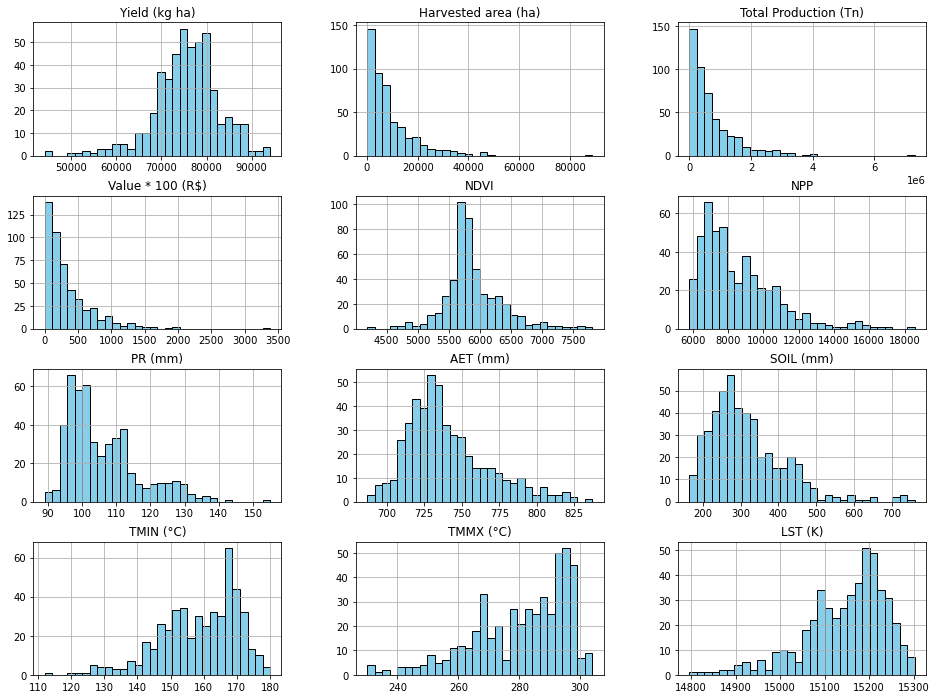

In [69]:
# HIstograms
fig = plt.figure(figsize = (16,12))
ax = fig.gca()
new_data_mean.hist(ax=ax, bins = 30, color = "skyblue", ec = 'black')
#plt.savefig('averages.png', dpi = 300)
plt.show()

#### Plots by years

In [70]:
# Group by years
new_by_year = pd.DataFrame(dat_yield_melt.groupby('Year')['Yield'].mean().reset_index()).astype(int)
st_yield = pd.DataFrame(dat_yield_melt.groupby('Year')['Yield'].std()).reset_index().astype(int)
st_yield.rename(columns = {'Yield': 'st_yield'}, inplace = True)

mean_ac = pd.DataFrame(dat_ac_melt.groupby('Year')['AC'].mean().reset_index()).astype(int)
st_ac = pd.DataFrame(dat_ac_melt.groupby('Year')['AC'].std().reset_index()).astype(int)
st_ac.rename(columns = {'AC': 'st_ac'}, inplace = True)

mean_qp = pd.DataFrame(dat_qp_melt.groupby('Year')['QP'].mean().reset_index()).astype(int)
st_qp = pd.DataFrame(dat_qp_melt.groupby('Year')['QP'].std().reset_index()).astype(int)
st_qp.rename(columns = {'QP': 'st_qp'}, inplace = True)

mean_vp = pd.DataFrame(dat_vp_melt.groupby('Year')['VP'].mean().reset_index()).astype(int)
st_vp = pd.DataFrame(dat_vp_melt.groupby('Year')['VP'].std().reset_index()).astype(int)
st_vp.rename(columns = {'VP': 'st_vp'}, inplace = True)

mean_ndvi = pd.DataFrame(dat_clean_ndvi.groupby('variable')['NDVI'].mean().reset_index())
st_ndvi = pd.DataFrame(dat_clean_ndvi.groupby('variable')['NDVI'].std().reset_index())
st_ndvi.rename(columns = {'NDVI': 'st_ndvi'}, inplace = True)

mean_npp = pd.DataFrame(dat_clean_npp.groupby('variable')['NPP'].mean().reset_index())
st_npp = pd.DataFrame(dat_clean_npp.groupby('variable')['NPP'].std().reset_index())
st_npp.rename(columns = {'NPP': 'st_npp'}, inplace = True)

mean_pr = pd.DataFrame(dat_clean_pr.groupby('variable')['PR'].mean().reset_index())
st_pr = pd.DataFrame(dat_clean_pr.groupby('variable')['PR'].std().reset_index())
st_pr.rename(columns = {'PR': 'st_pr'}, inplace = True)

mean_aet = pd.DataFrame(dat_clean_aet.groupby('variable')['AET'].mean().reset_index())
st_aet = pd.DataFrame(dat_clean_aet.groupby('variable')['AET'].std().reset_index())
st_aet.rename(columns = {'AET': 'st_aet'}, inplace = True)

mean_soil = pd.DataFrame(dat_clean_soil.groupby('variable')['SOIL'].mean().reset_index())
st_soil = pd.DataFrame(dat_clean_soil.groupby('variable')['SOIL'].std().reset_index())
st_soil.rename(columns = {'SOIL': 'st_soil'}, inplace = True)

mean_tmin = pd.DataFrame(dat_clean_tmin.groupby('variable')['TMIN'].mean().reset_index())
st_tmin = pd.DataFrame(dat_clean_tmin.groupby('variable')['TMIN'].std().reset_index())
st_tmin.rename(columns = {'TMIN': 'st_tmin'}, inplace = True)

mean_tmmx = pd.DataFrame(dat_clean_tmmx.groupby('variable')['TMMX'].mean().reset_index())
st_tmmx = pd.DataFrame(dat_clean_tmmx.groupby('variable')['TMMX'].std().reset_index())
st_tmmx.rename(columns = {'TMMX': 'st_tmmx'}, inplace = True)

mean_lst = pd.DataFrame(dat_clean_lst.groupby('variable')['LST'].mean().reset_index())
st_lst = pd.DataFrame(dat_clean_lst.groupby('variable')['LST'].std().reset_index())
st_lst.rename(columns = {'LST': 'st_lst'}, inplace = True)

In [71]:
# Join all together
new_data_by_year = new_by_year.join([st_yield['st_yield'], mean_ac['AC'], st_ac['st_ac'], mean_qp['QP'], st_qp['st_qp'],
                                    mean_vp['VP'], st_vp['st_vp'], mean_ndvi['NDVI'], st_ndvi['st_ndvi'], mean_npp['NPP'],
                                    st_npp['st_npp'], mean_pr['PR'], st_pr['st_pr'], mean_aet['AET'], st_aet['st_aet'],
                                    mean_soil['SOIL'], st_soil['st_soil'], mean_tmin['TMIN'], st_tmin['st_tmin'],
                                    mean_tmmx['TMMX'], st_tmmx['st_tmmx'], mean_lst['LST'], st_lst['st_lst']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')

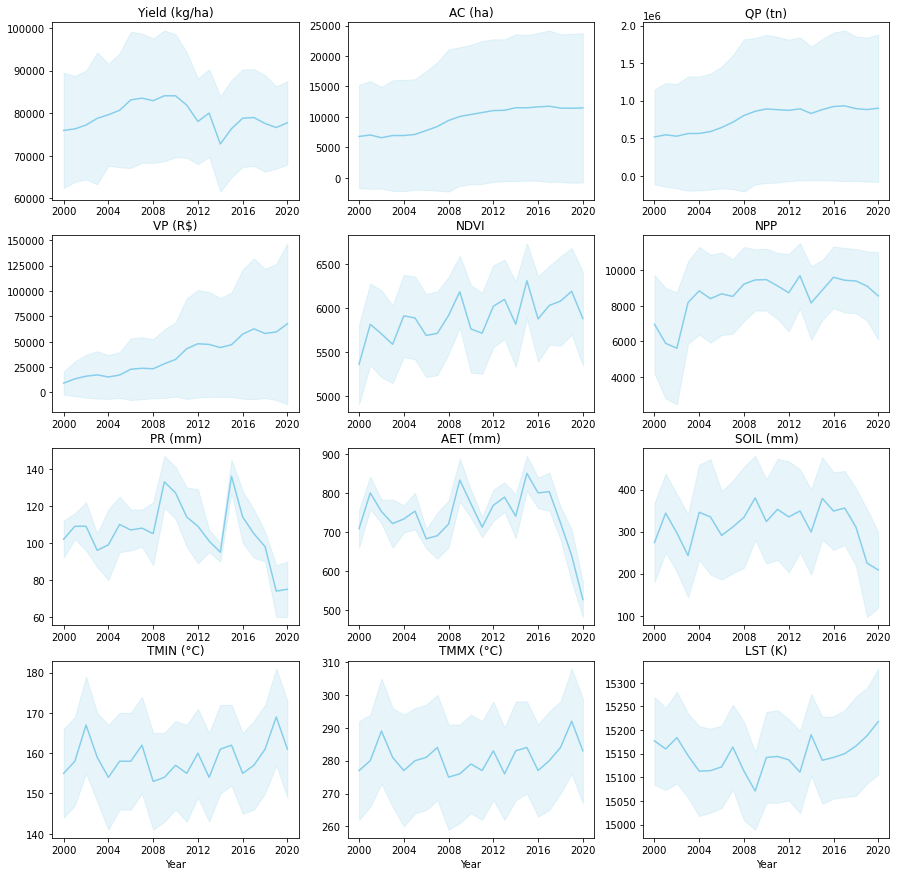

In [72]:
# Graph of each variable by year
plt.figure(figsize = (15,15))
plt.subplot(4,3,1)
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.title('Yield (kg/ha)')

plt.subplot(4,3,2)
plt.plot(new_data_by_year['Year'], new_data_by_year['AC'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['AC'] + new_data_by_year['st_ac']), 
                 (new_data_by_year['AC'] - new_data_by_year['st_ac']), alpha = 0.2, color = 'skyblue')
plt.title('AC (ha)')

plt.subplot(4,3,3)
plt.plot(new_data_by_year['Year'], new_data_by_year['QP'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['QP'] + new_data_by_year['st_qp']), 
                 (new_data_by_year['QP'] - new_data_by_year['st_qp']), alpha = 0.2, color = 'skyblue')
plt.title('QP (tn)')

plt.subplot(4,3,4)
plt.plot(new_data_by_year['Year'], new_data_by_year['VP'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['VP'] + new_data_by_year['st_vp']), 
                 (new_data_by_year['VP'] - new_data_by_year['st_vp']), alpha = 0.2, color = 'skyblue')
plt.title('VP (R$)')

plt.subplot(4,3,5)
plt.plot(new_data_by_year['Year'], new_data_by_year['NDVI'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['NDVI'] + new_data_by_year['st_ndvi']), 
                 (new_data_by_year['NDVI'] - new_data_by_year['st_ndvi']), alpha = 0.2, color = 'skyblue')
plt.title('NDVI')

plt.subplot(4,3,6)
plt.plot(new_data_by_year['Year'], new_data_by_year['NPP'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['NPP'] + new_data_by_year['st_npp']), 
                 (new_data_by_year['NPP'] - new_data_by_year['st_npp']), alpha = 0.2, color = 'skyblue')
plt.title('NPP')

plt.subplot(4,3,7)
plt.plot(new_data_by_year['Year'], new_data_by_year['PR'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['PR'] + new_data_by_year['st_pr']), 
                 (new_data_by_year['PR'] - new_data_by_year['st_pr']), alpha = 0.2, color = 'skyblue')
plt.title('PR (mm)')

plt.subplot(4,3,8)
plt.plot(new_data_by_year['Year'], new_data_by_year['AET'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['AET'] + new_data_by_year['st_aet']), 
                 (new_data_by_year['AET'] - new_data_by_year['st_aet']), alpha = 0.2, color = 'skyblue')
plt.title('AET (mm)')

plt.subplot(4,3,9)
plt.plot(new_data_by_year['Year'], new_data_by_year['SOIL'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['SOIL'] + new_data_by_year['st_soil']), 
                 (new_data_by_year['SOIL'] - new_data_by_year['st_soil']), alpha = 0.2, color = 'skyblue')
plt.title('SOIL (mm)')

plt.subplot(4,3,10)
plt.plot(new_data_by_year['Year'], new_data_by_year['TMIN'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['TMIN'] + new_data_by_year['st_tmin']), 
                 (new_data_by_year['TMIN'] - new_data_by_year['st_tmin']), alpha = 0.2, color = 'skyblue')
plt.title('TMIN (°C)')
plt.xlabel('Year')

plt.subplot(4,3,11)
plt.plot(new_data_by_year['Year'], new_data_by_year['TMMX'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['TMMX'] + new_data_by_year['st_tmmx']), 
                 (new_data_by_year['TMMX'] - new_data_by_year['st_tmmx']), alpha = 0.2, color = 'skyblue')
plt.title('TMMX (°C)')
plt.xlabel('Year')

plt.subplot(4,3,12)
plt.plot(new_data_by_year['Year'], new_data_by_year['LST'], color = 'skyblue')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['LST'] + new_data_by_year['st_lst']), 
                 (new_data_by_year['LST'] - new_data_by_year['st_lst']), alpha = 0.2, color = 'skyblue')
plt.title('LST (K)')
plt.xlabel('Year')

#plt.savefig('averages_by_year.png', dpi = 300)
plt.show()

#### Graphs by quantile by year

In [73]:
# Re-organize the data - Transpose
yield_grouped.drop(['quantiles_yield'], axis = 1, inplace = True)
dat_clean_grouped_trans = yield_grouped.T
dat_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
dat_clean_grouped_trans.index = pd.to_datetime(dat_clean_grouped_trans.index)
dat_clean_grouped_trans.head()

q1     q2     q3     q4     q5
2000-01-01  65799  73683  74812  80359  86921
2001-01-01  66738  73119  78316  79011  85098
2002-01-01  64080  75198  79181  81160  88606
2003-01-01  65146  77278  78861  83336  91267
2004-01-01  66405  77669  80452  85100  88716

In [74]:
# Re-organize the data - Transpose
ac_grouped.drop(['quantiles'], axis = 1, inplace = True)
ac_clean_grouped_trans = ac_grouped.T
ac_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
ac_clean_grouped_trans.index = pd.to_datetime(ac_clean_grouped_trans.index)
ac_clean_grouped_trans.head()

q1    q2    q3    q4    q5
2000-01-01  3554  7822  7119  8446  6659
2001-01-01  3599  7671  7386  9189  6881
2002-01-01  3098  7883  6552  8927  6414
2003-01-01  3335  7987  7038  9660  6490
2004-01-01  3468  7934  7119  9626  6186

In [75]:
# Re-organize the data - Transpose
qp_grouped.drop(['quantiles'], axis = 1, inplace = True)
qp_clean_grouped_trans = qp_grouped.T
qp_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
qp_clean_grouped_trans.index = pd.to_datetime(qp_clean_grouped_trans.index)
qp_clean_grouped_trans.head()

q1      q2      q3      q4      q5
2000-01-01  234130  560907  542044  669874  556949
2001-01-01  246013  568934  571066  734905  574011
2002-01-01  213267  591576  515373  743814  574221
2003-01-01  225149  610777  560708  818316  585947
2004-01-01  246992  606748  565287  821719  547075

In [76]:
# Re-organize the data - Transpose
vp_grouped.drop(['quantiles'], axis = 1, inplace = True)
vp_clean_grouped_trans = vp_grouped.T
vp_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
vp_clean_grouped_trans.index = pd.to_datetime(vp_clean_grouped_trans.index)
vp_clean_grouped_trans.head()

q1     q2     q3     q4     q5
2000-01-01  4177  10007   9670  11951   9936
2001-01-01  6071  14043  14130  18157  14185
2002-01-01  6498  18025  15703  22664  17497
2003-01-01  7218  19453  17543  24303  18131
2004-01-01  7086  17280  15375  21664  14466

In [77]:
# Re-organize the data - Transpose
ndvi_grouped.rename(columns = {'NDVI_2000': '2000', 'NDVI_2001': '2001', 'NDVI_2002': '2002', 
                              'NDVI_2003': '2003', 'NDVI_2004': '2004', 'NDVI_2005': '2005', 'NDVI_2006': '2006',
                               'NDVI_2007': '2007','NDVI_2008': '2008', 'NDVI_2009':'2009', 'NDVI_2010': '2010',
                               'NDVI_2011': '2011', 'NDVI_2012':'2012', 'NDVI_2013': '2013', 'NDVI_2014': '2014', 
                               'NDVI_2015': '2015', 'NDVI_2016': '2016', 'NDVI_2017': '2017',
                              'NDVI_2018': '2018', 'NDVI_2019': '2019', 'NDVI_2020': '2020', 'NDVI_2021': '2021'}, 
                    inplace = True)
ndvi_grouped.drop(['quantiles'], axis = 1, inplace = True)
ndvi_clean_grouped_trans = ndvi_grouped.T
ndvi_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
ndvi_clean_grouped_trans.index = pd.to_datetime(ndvi_clean_grouped_trans.index)
ndvi_clean_grouped_trans = ndvi_clean_grouped_trans.head(21)

In [78]:
# Re-organize the data - Transpose
npp_grouped.rename(columns = {'npp_2000': '2000', 'npp_2001': '2001', 'npp_2002': '2002', 
                              'npp_2003': '2003', 'npp_2004': '2004', 'npp_2005': '2005', 'npp_2006': '2006',
                               'npp_2007': '2007','npp_2008': '2008', 'npp_2009':'2009', 'npp_2010': '2010',
                               'npp_2011': '2011', 'npp_2012':'2012', 'npp_2013': '2013', 'npp_2014': '2014', 
                               'npp_2015': '2015', 'npp_2016': '2016', 'npp_2017': '2017',
                              'npp_2018': '2018', 'npp_2019': '2019', 'npp_2020': '2020', 'npp_2021': '2021'}, 
                    inplace = True)
npp_grouped.drop(['quantiles'], axis = 1, inplace = True)
npp_clean_grouped_trans = npp_grouped.T
npp_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
npp_clean_grouped_trans.index = pd.to_datetime(npp_clean_grouped_trans.index)
npp_clean_grouped_trans = npp_clean_grouped_trans.head(21)
npp_clean_grouped_trans.head()

q1    q2    q3    q4    q5
2000-01-01   8286  6662  6687  6800  6377
2001-01-01   7579  5628  5591  5553  5122
2002-01-01   7188  5280  5264  5410  4946
2003-01-01   9499  7950  7960  7905  7611
2004-01-01  10090  8616  8640  8607  8255

In [79]:
# Re-organize the data - Transpose
pr_grouped.rename(columns = {'pr_2000': '2000', 'pr_2001': '2001', 'pr_2002': '2002', 
                              'pr_2003': '2003', 'pr_2004': '2004', 'pr_2005': '2005', 'pr_2006': '2006',
                               'pr_2007': '2007','pr_2008': '2008', 'pr_2009':'2009', 'pr_2010': '2010',
                               'pr_2011': '2011', 'pr_2012':'2012', 'pr_2013': '2013', 'pr_2014': '2014', 
                               'pr_2015': '2015', 'pr_2016': '2016', 'pr_2017': '2017',
                              'pr_2018': '2018', 'pr_2019': '2019', 'pr_2020': '2020', 'pr_2021': '2021'}, 
                    inplace = True)
pr_grouped.drop(['quantiles'], axis = 1, inplace = True)
pr_clean_grouped_trans = pr_grouped.T
pr_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
pr_clean_grouped_trans.index = pd.to_datetime(pr_clean_grouped_trans.index)
pr_clean_grouped_trans = pr_clean_grouped_trans.head(21)
pr_clean_grouped_trans.head()

q1   q2   q3   q4   q5
2000-01-01  102  101  102  104  101
2001-01-01  110  109  109  110  108
2002-01-01  112  109  109  112  108
2003-01-01   95   96   97   97   97
2004-01-01  105   98   98  101   96

In [80]:
# Re-organize the data - Transpose
aet_grouped.rename(columns = {'aet_2000': '2000', 'aet_2001': '2001', 'aet_2002': '2002', 
                              'aet_2003': '2003', 'aet_2004': '2004', 'aet_2005': '2005', 'aet_2006': '2006',
                               'aet_2007': '2007','aet_2008': '2008', 'aet_2009':'2009', 'aet_2010': '2010',
                               'aet_2011': '2011', 'aet_2012':'2012', 'aet_2013': '2013', 'aet_2014': '2014', 
                               'aet_2015': '2015', 'aet_2016': '2016', 'aet_2017': '2017',
                              'aet_2018': '2018', 'aet_2019': '2019', 'aet_2020': '2020', 'aet_2021': '2021'}, 
                    inplace = True)
aet_grouped.drop(['quantiles'], axis = 1, inplace = True)
aet_clean_grouped_trans = aet_grouped.T
aet_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
aet_clean_grouped_trans.index = pd.to_datetime(aet_clean_grouped_trans.index)
aet_clean_grouped_trans = aet_clean_grouped_trans.head(21)
aet_clean_grouped_trans.head()

q1   q2   q3   q4   q5
2000-01-01  724  713  713  700  698
2001-01-01  804  806  807  794  798
2002-01-01  759  751  760  753  743
2003-01-01  710  725  729  720  729
2004-01-01  733  735  741  736  727

In [81]:
# Re-organize the data - Transpose
soil_grouped.rename(columns = {'soil_2000': '2000', 'soil_2001': '2001', 'soil_2002': '2002', 
                              'soil_2003': '2003', 'soil_2004': '2004', 'soil_2005': '2005', 'soil_2006': '2006',
                               'soil_2007': '2007','soil_2008': '2008', 'soil_2009':'2009', 'soil_2010': '2010',
                               'soil_2011': '2011', 'soil_2012':'2012', 'soil_2013': '2013', 'soil_2014': '2014', 
                               'soil_2015': '2015', 'soil_2016': '2016', 'soil_2017': '2017',
                              'soil_2018': '2018', 'soil_2019': '2019', 'soil_2020': '2020', 'soil_2021': '2021'}, 
                    inplace = True)
soil_grouped.drop(['quantiles'], axis = 1, inplace = True)
soil_clean_grouped_trans = soil_grouped.T
soil_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
soil_clean_grouped_trans.index = pd.to_datetime(soil_clean_grouped_trans.index)
soil_clean_grouped_trans = soil_clean_grouped_trans.head(21)
soil_clean_grouped_trans.head()

q1   q2   q3   q4   q5
2000-01-01  275  249  277  302  271
2001-01-01  351  321  347  364  339
2002-01-01  312  272  303  313  288
2003-01-01  251  219  241  264  243
2004-01-01  373  322  348  359  332

In [82]:
# Re-organize the data - Transpose
tmin_grouped.rename(columns = {'tminx_2000': '2000', 'tminx_2001': '2001', 'tminx_2002': '2002', 
                              'tminx_2003': '2003', 'tminx_2004': '2004', 'tminx_2005': '2005', 'tminx_2006': '2006',
                               'tminx_2007': '2007','tminx_2008': '2008', 'tminx_2009':'2009', 'tminx_2010': '2010',
                               'tminx_2011': '2011', 'tminx_2012':'2012', 'tminx_2013': '2013', 'tminx_2014': '2014', 
                               'tminx_2015': '2015', 'tminx_2016': '2016', 'tminx_2017': '2017',
                              'tminx_2018': '2018', 'tminx_2019': '2019', 'tminx_2020': '2020', 'tminx_2021': '2021'}, 
                    inplace = True)
tmin_grouped.drop(['quantiles'], axis = 1, inplace = True)
tmin_clean_grouped_trans = tmin_grouped.T
tmin_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
tmin_clean_grouped_trans.index = pd.to_datetime(tmin_clean_grouped_trans.index)
tmin_clean_grouped_trans = tmin_clean_grouped_trans.head(21)
tmin_clean_grouped_trans.head()

q1   q2   q3   q4   q5
2000-01-01  150  156  156  158  158
2001-01-01  154  159  159  161  161
2002-01-01  162  168  168  170  170
2003-01-01  154  160  160  162  162
2004-01-01  149  155  155  157  158

In [83]:
# Re-organize the data - Transpose
tmmx_grouped.rename(columns = {'tmmx_2000': '2000', 'tmmx_2001': '2001', 'tmmx_2002': '2002', 
                              'tmmx_2003': '2003', 'tmmx_2004': '2004', 'tmmx_2005': '2005', 'tmmx_2006': '2006',
                               'tmmx_2007': '2007','tmmx_2008': '2008', 'tmmx_2009':'2009', 'tmmx_2010': '2010',
                               'tmmx_2011': '2011', 'tmmx_2012':'2012', 'tmmx_2013': '2013', 'tmmx_2014': '2014', 
                               'tmmx_2015': '2015', 'tmmx_2016': '2016', 'tmmx_2017': '2017',
                              'tmmx_2018': '2018', 'tmmx_2019': '2019', 'tmmx_2020': '2020', 'tmmx_2021': '2021'}, 
                    inplace = True)
tmmx_grouped.drop(['quantiles'], axis = 1, inplace = True)
tmmx_clean_grouped_trans = tmmx_grouped.T
tmmx_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
tmmx_clean_grouped_trans.index = pd.to_datetime(tmmx_clean_grouped_trans.index)
tmmx_clean_grouped_trans = tmmx_clean_grouped_trans.head(21)
tmmx_clean_grouped_trans.head()

q1   q2   q3   q4   q5
2000-01-01  270  278  279  280  281
2001-01-01  274  281  282  283  283
2002-01-01  281  290  291  292  293
2003-01-01  275  282  283  284  285
2004-01-01  269  277  279  279  280

In [84]:
# Re-organize the data - Transpose
lst_grouped.rename(columns = {'LST_2000': '2000', 'LST_2001': '2001', 'LST_2002': '2002', 
                              'LST_2003': '2003', 'LST_2004': '2004', 'LST_2005': '2005', 'LST_2006': '2006',
                               'LST_2007': '2007','LST_2008': '2008', 'LST_2009':'2009', 'LST_2010': '2010',
                               'LST_2011': '2011', 'LST_2012':'2012', 'LST_2013': '2013', 'LST_2014': '2014', 
                               'LST_2015': '2015', 'LST_2016': '2016', 'LST_2017': '2017',
                              'LST_2018': '2018', 'LST_2019': '2019', 'LST_2020': '2020', 'LST_2021': '2021'}, 
                    inplace = True)
lst_grouped.drop(['quantiles'], axis = 1, inplace = True)
lst_clean_grouped_trans = lst_grouped.T
lst_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
lst_clean_grouped_trans.index = pd.to_datetime(lst_clean_grouped_trans.index)
lst_clean_grouped_trans = lst_clean_grouped_trans.head(21)
lst_clean_grouped_trans.head()

q1     q2     q3     q4     q5
2000-01-01  15120  15181  15185  15195  15205
2001-01-01  15107  15164  15162  15181  15188
2002-01-01  15130  15186  15192  15203  15213
2003-01-01  15096  15153  15152  15158  15172
2004-01-01  15068  15120  15116  15122  15142

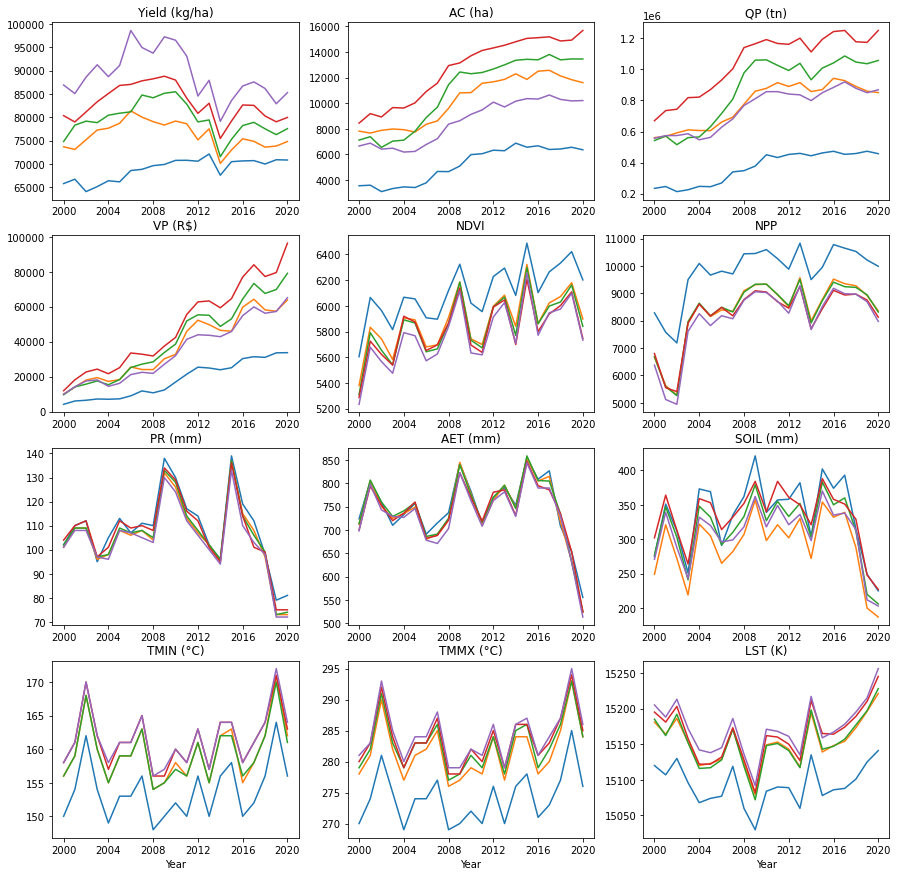

In [85]:
## Plot quantiles
legenda = np.array(["Q1","Q2","Q3","Q4", "Q5"])

plt.subplots(figsize=(15,15))

plt.subplot(4,3,1)
plt.plot(dat_clean_grouped_trans)
plt.title('Yield (kg/ha)')

plt.subplot(4,3,2)
plt.plot(ac_clean_grouped_trans)
plt.title('AC (ha)')

plt.subplot(4,3,3)
plt.plot(qp_clean_grouped_trans)
plt.title('QP (tn)')

plt.subplot(4,3,4)
plt.plot(vp_clean_grouped_trans)
plt.title('VP (R$)')

plt.subplot(4,3,5)
plt.plot(ndvi_clean_grouped_trans)
plt.title('NDVI')

plt.subplot(4,3,6)
plt.plot(npp_clean_grouped_trans)
plt.title('NPP')

plt.subplot(4,3,7)
plt.plot(pr_clean_grouped_trans)
plt.title('PR (mm)')

plt.subplot(4,3,8)
plt.plot(aet_clean_grouped_trans)
plt.title('AET (mm)')

plt.subplot(4,3,9)
plt.plot(soil_clean_grouped_trans)
plt.title('SOIL (mm)')

plt.subplot(4,3,10)
plt.plot(tmin_clean_grouped_trans)
plt.title('TMIN (°C)')
plt.xlabel('Year')

plt.subplot(4,3,11)
plt.plot(tmmx_clean_grouped_trans)
plt.title('TMMX (°C)')
plt.xlabel('Year')

plt.subplot(4,3,12)
plt.plot(lst_clean_grouped_trans)
plt.title('LST (K)')
plt.xlabel('Year')

#plt.savefig('averages_by_quantiles.png', dpi=300)
plt.show()

### Part 2: Loading and plotting the rasters

In [86]:
# Load and open rasters
with rasterio.open("raster/NDVI_2000-2021.tif") as NDVI_stack:
    NDVI_stack_data = NDVI_stack.read(masked=True)
    NDVI_stack_meta = NDVI_stack.profile
    
with rasterio.open("raster/LST_2000-2021.tif") as LST_stack:
    LST_stack_data = LST_stack.read()
    LST_stack_meta = LST_stack.profile
    
with rasterio.open("raster/tmin_bands.tif") as tmin_stack:
    tmin_stack_data = tmin_stack.read()
    tmin_stack_meta = tmin_stack.profile
    
with rasterio.open("raster/tmmx_bands.tif") as tmmx_stack:
    tmmx_stack_data = tmmx_stack.read()
    tmmx_stack_meta = tmmx_stack.profile
    
with rasterio.open("raster/soil_bands.tif") as soil_stack:
    soil_stack_data = soil_stack.read()
    soil_stack_meta = soil_stack.profile
    
with rasterio.open("raster/pr_bands.tif") as pr_stack:
    pr_stack_data = pr_stack.read()
    pr_stack_meta = pr_stack.profile
    
with rasterio.open("raster/aet_bands.tif") as aet_stack:
    aet_stack_data = aet_stack.read()
    aet_stack_meta = aet_stack.profile

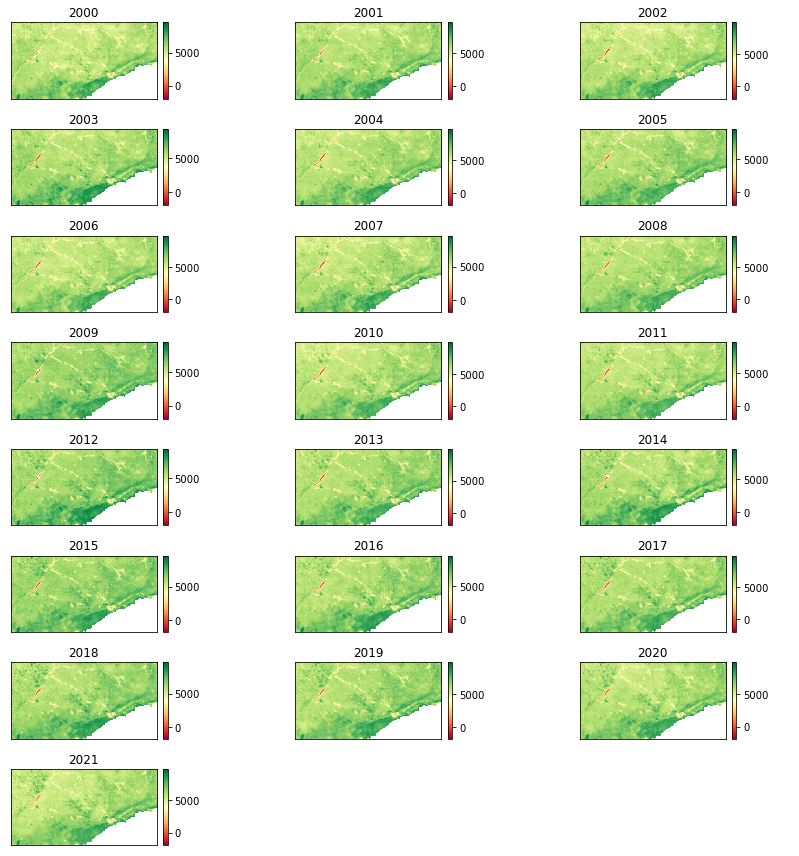

In [87]:
# Plot rasters - NDVI
band_titles=list(range(2000, 2022))

ep.plot_bands(NDVI_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

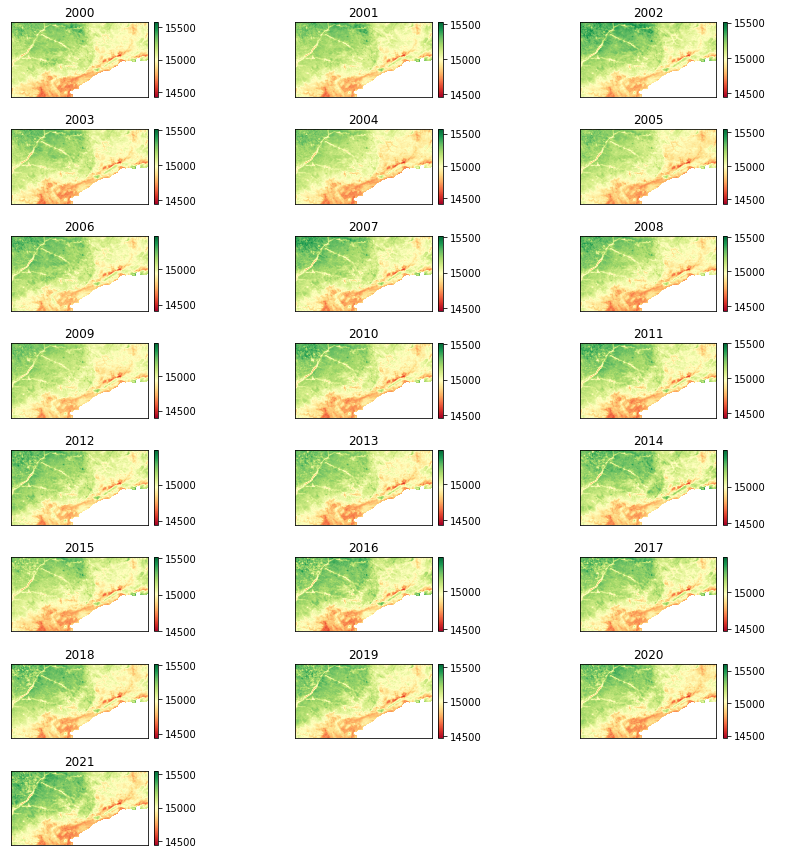

In [88]:
# Plot rasters - LST
ep.plot_bands(LST_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

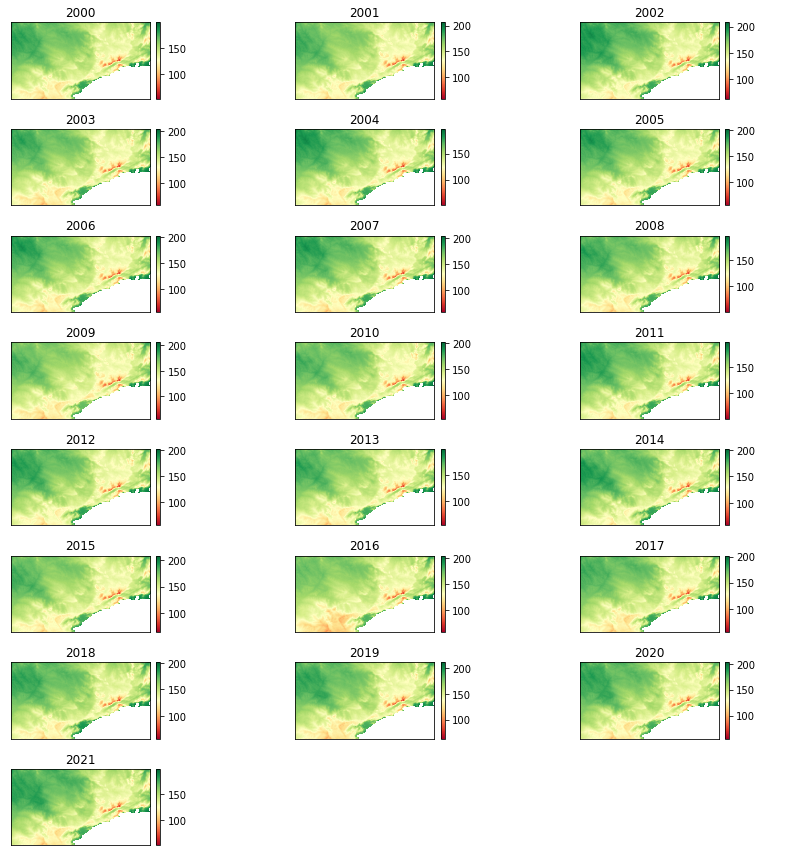

In [89]:
# Plot rasters - T min
ep.plot_bands(tmin_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

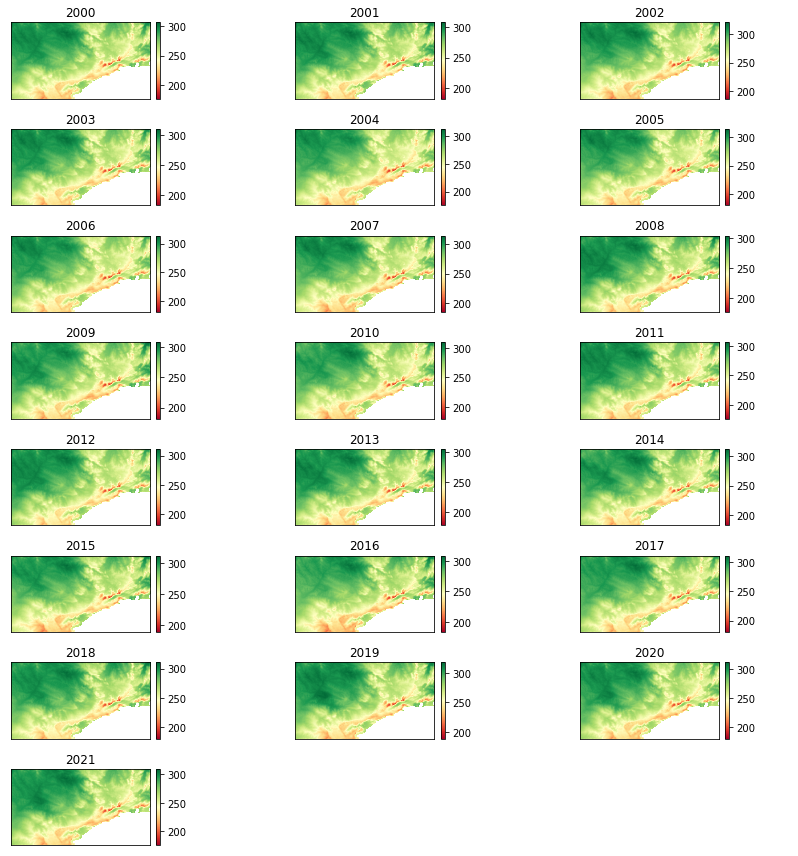

In [90]:
# Plot rasters - T max
ep.plot_bands(tmmx_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()   

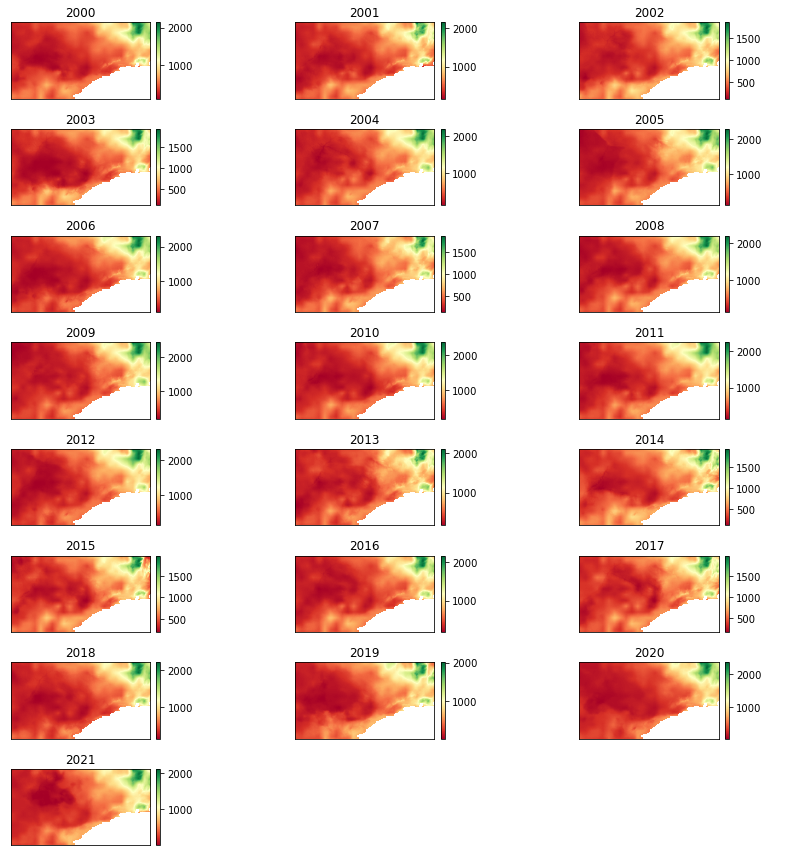

In [91]:
# Plot rasters - Soil moisture
ep.plot_bands(soil_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

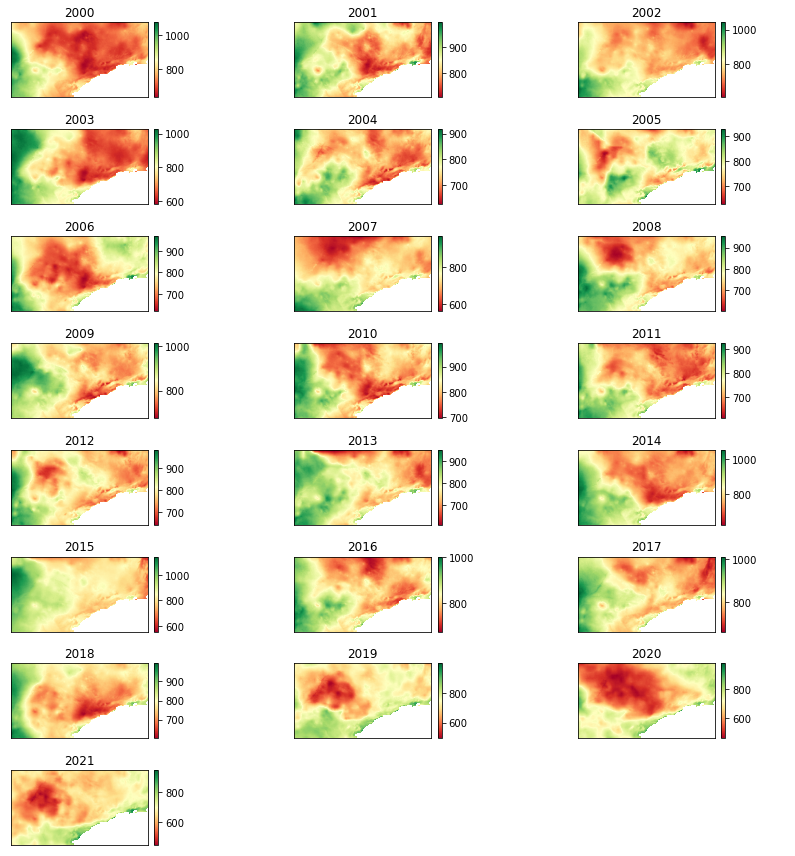

In [92]:
# Plot rasters - Evapotranspiration
ep.plot_bands(aet_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

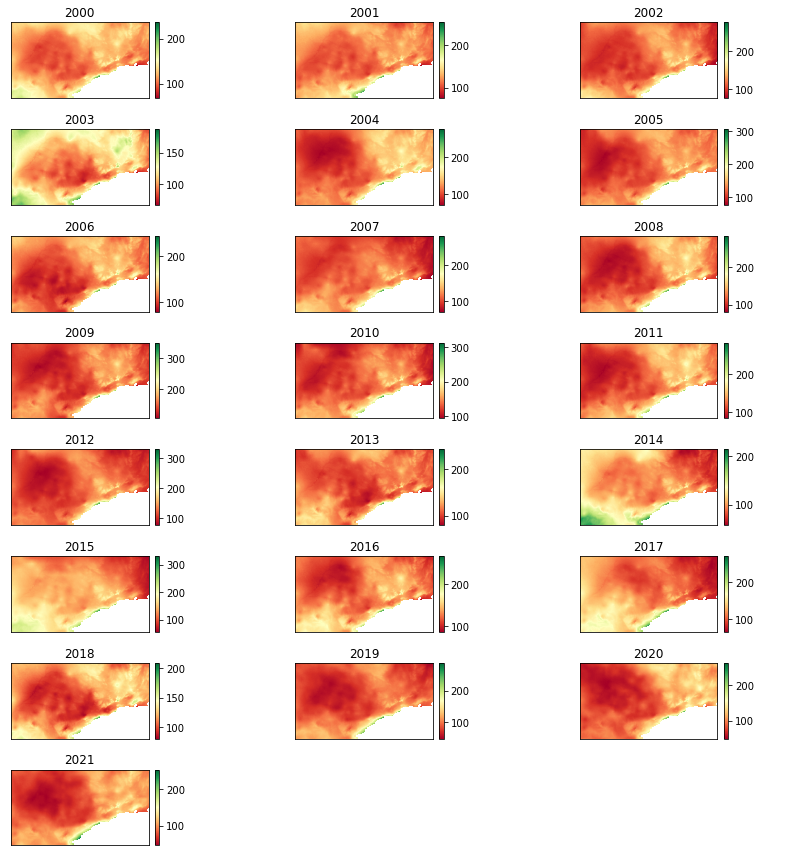

In [93]:
# Plot rasters - Precipitation
ep.plot_bands(pr_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
## End